### Source Code From https://github.com/skadudd/power_demand/blob/master/eda.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gc

In [ ]:
# api 겟
api_list = pd.read_csv('./API.csv')

api_weather = api_list.key[0]
api_pw_home = api_list.key[1]

In [42]:
weather_1h = pd.read_csv('./data/weather_fromland_20130101_20230515.csv')
# weather_meta = pd.read_csv('./data/META_관측지점정보_20230516003910_v2.csv',encoding='euc-kr')
# power_demand_1h = pd.read_csv('./data/시간별 전력수요량 2013-2021.csv')

weather_1h.drop(weather_1h.columns[:2],axis=1,inplace=True)
weather_1h.drop(['CT_nan','CT_nan.2'],axis=1,inplace=True)

### 기상정보 1h 정리

In [16]:
# 기상 1시간짜리, 컬럼 스크랩
import requests
from bs4 import BeautifulSoup
import re

api_weather = '36MMtU5BTwijDLVOQZ8ISw'
url = f'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm3.php?tm1=201512110100&tm2=201512140000&stn=108&help=1&authKey={api_weather}'

res = requests.get(url)
soup = BeautifulSoup(res.text,'html.parser')
df_info = soup.text.split('\n')[4:50]

df_info = pd.DataFrame(df_info)
df_info[0] = df_info[0].str.strip()

def reg_drop_num(x):
    regex = r"#\s*\d+\."
    
    match = re.split(regex, x)
    return match[1]

def reg_split(x):
    regex = r"\s*:\s*"
    
    match = re.split(regex, x)
    return match[0],match[1]

df_info[0] = df_info[0].apply(reg_drop_num)
df_info['code'],df_info[0] =zip(*df_info[0].apply(reg_split))

df_info.rename(columns={0:'desc'},inplace=True)
df_info['code'] = df_info['code'].str.strip()


In [17]:
# 기상청 정보 컬럼과 컬럼명 얼라인
weather_1h.rename(columns=dict(zip(weather_1h.columns,list(df_info['code']))),inplace=True)

In [18]:
# 메타데이터 정리
weather_meta.loc[weather_meta['지점명']=='무안','지점주소'] = '전라남도 무안군 망운면 피서리'
weather_meta['도'] = weather_meta['지점주소'].str.split(' ').str[0]
weather_meta_b = weather_meta[['지점','도','지점명','관리관서']]
weather_meta_b.rename(columns={'지점':'STN'},inplace=True)
weather_meta_b.drop_duplicates(subset='STN',inplace=True)
weather_meta_b

C:\Users\jiho\AppData\Local\Temp\ipykernel_2328\251032057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_meta_b.rename(columns={'지점':'STN'},inplace=True)
C:\Users\jiho\AppData\Local\Temp\ipykernel_2328\251032057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_meta_b.drop_duplicates(subset='STN',inplace=True)


,STN,도,지점명,관리관서
0,90,강원도,속초,속초기상대(90)
1,93,강원도,북춘천,춘천기상대(101)
2,95,강원도,철원,춘천기상대(101)
3,98,경기도,동두천,수도권기상청(119)
4,99,경기도,파주,수도권기상청(119)
...,...,...,...,...
2403,989,NaN,안덕화순,제주지방기상청(184)
2404,990,NaN,낙천,제주지방기상청(184)
2406,991,NaN,옥포,대구(구 143)
2407,992,NaN,하빈,대구(구 143)


In [19]:
# #기상데이터 메타정보와 합치기

weather = weather_1h.merge(weather_meta_b,on='STN',how='left')
weather.drop(['WC','WP','WW','CT','CT_TOP','CT_MID','CT_LOW','ST_GD','ST_SEA','IR','IX'],axis=1,inplace=True)
weather.drop(['GST_WD','GST_WS','GST_TM','PT','PR','RN_INT','RN_JUN','SD_HR3','SD_TOT'],axis=1,inplace=True)
weather.drop(['BF'],axis=1,inplace=True)
weather.drop(['TE_005','TE_01','TE_02','TE_03'],axis=1,inplace=True)
weather.drop(['WD'],axis=1,inplace=True)
weather.drop(['지점명','관리관서'],axis=1,inplace=True)

In [20]:
# 기상 인포와 현재 컬럼 확인
df_info[df_info['code'].isin(list(weather.columns))]

,desc,code
0,관측시각 (KST),TM
1,국내 지점번호,STN
3,풍속 (m/s),WS
7,현지기압 (hPa),PA
8,해면기압 (hPa),PS
11,기온 (C),TA
12,이슬점온도 (C),TD
13,상대습도 (%),HM
14,수증기압 (hPa),PV
15,강수량 (mm),RN


In [13]:
#결측치 처리
def nan_to_alter(target_col,nan_val,alter_val):
    weather.loc[weather[target_col]==nan_val,target_col] = alter_val

targets = ['WS','PA','PS','HM','PV','RN','RN_DAY','SD_DAY','CA_TOT','CA_MID','CH_MIN','VS','SS','SI','WH']

for col in list(targets):

    if str(weather[col].dtype) == 'int64':
        # isin = weather[col].isin([-9]).sum()
        nan_val = -9
        alter_val = 0
    else:
        isin = weather[col].isin([-9.0]).sum()
        nan_val = -9.0
        alter_val = 0.0

    nan_to_alter(col,nan_val,alter_val)

In [386]:
# 날짜 피보팅 및 시간타입 변경
# weather.drop(['STN'],axis=1,inplace=True)
# weather_pv = weather.groupby(['TM','도']).mean().reset_index()
# weather_pv['TM'] = pd.to_datetime(weather_pv['TM'],format='%Y-%m-%d %H:%M')
# weather_pv

weather_pv.to_pickle('./processed_df/weather_pv.pkl')

### 기상정보 1m AWS

In [795]:
start_date = '2021-01-01 00:01'
end_date = '202304020000'

start_date = dt.datetime.strptime(start_date, "%Y-%m-%d %H:%M")
start_date = dt.datetime.strptime(start_date, "%Y-%m-%d %H:%M")
# start_date = datetime.datetime.strptime(start_date,"%Y%m%d %H : %m").date()
# end_date = datetime.datetime.strptime(end_date,"%Y%m%d").date()
start_date
# start_date + datetime.timedelta(1)



start_date.minute



1

In [792]:
dt.datetime.strptime("2017-01-02 14:44", "%Y-%m-%d %H:%M")

datetime.datetime(2017, 1, 2, 14, 44)

In [ ]:
def get_weather_fromland(start_date,end_date,auth) -> pd.DataFrame:
    import datetime
    
    #날짜 정의
    start_date = str(start_date)
    end_date = str(end_date)
    start_date = datetime.datetime.strptime(start_date,"%Y%m%d").date()
    end_date = datetime.datetime.strptime(end_date,"%Y%m%d").date()
    days = (end_date - start_date).days + 1

    #API 정의
    'https://apihub.kma.go.kr/api/typ01/cgi-bin/url/nph-aws2_min?tm1=202302010000&tm2=202302010300&stn=0&disp=0&help=1&authKey=xt8GKubTSfyfBirm0yn8TQ'
    base = 'https://apihub.kma.go.kr/api/typ01/url/kma_sfctm3.php?'
    authKey=f'authKey={auth}'
    
    # 빈 df 정의
    # df =  pd.DataFrame()
    df_list = []
    df = pd.DataFrame()
    # API 호출
    if days > 29:
        batch = (days - 1) // 29 + 1
    else:
        batch = 1
    for i in range(batch):
        
        if start_date + datetime.timedelta(1) == end_date:
            break
        elif i+1 == batch:
            
            to_date = start_date + datetime.timedelta(days % 29 - 1)
        else:
            to_date = start_date + datetime.timedelta(29 - 1)
             
        # 날짜 텍스트화
        str_from_date = start_date.strftime('%Y%m%d')
        str_to_date = to_date.strftime('%Y%m%d')
        # url 정의
        url = base + f'tm1={str_from_date}0000&' + f'tm2={str_to_date}2300&' + 'help=0&' + authKey
        print(f'current_batch : {i + 1}/{batch}, current_date : {str_from_date} - {str_to_date}')
        # 데이터 생성
        try:
            print(url)
            df_tmp = get_parse_weather(url)
        except:
            print(f'error occured on {str_to_date}')
            df = pd.concat([df,df_tmp])
            break
        
        # df = pd.concat([df,df_tmp])
        df_list.append(df_tmp)
        # 시작일 재정의
        start_date = to_date + datetime.timedelta(1)
        print(days)

    for i in df_list:
        df = pd.concat([df,i])
    # 날짜 형식 변환
    df['datetime'] = pd.to_datetime(df['YYMMDDHHMI_KST'], format='%Y%m%d%H%M')
    df['datetime'] = df['datetime'].apply(lambda x : x.strftime(format='%Y-%m-%d %H:%M'))
    
    # 컬럼 순서 정리
    df.drop(['YYMMDDHHMI_KST'],axis=1,inplace=True)
    cols = df.columns.tolist()
    cols = [cols[-1]] + [col for col in cols[:-1]]
    df = df[cols]

    return df

def get_parse_weather(url):
    df =  pd.DataFrame()
    res = requests.get(url)
    soup = BeautifulSoup(res.text,'html.parser')

    col_1d = soup.text.split('\n')[2]
    col_2d = soup.text.split('\n')[3]
    data = soup.text.split('\n')[4:-2]

    # 행 정리
    df = pd.DataFrame(data, columns=['data'])
    df = pd.concat([df['data'].str.split(expand=True)], axis=1)
    
    # 컬럼 정리
    col_1d = col_1d.split()[1:]
    col_2d = col_2d.split()[1:]

    col_2d.insert(col_2d.index('LOW'),'-')
    col_2d.insert(col_2d.index('LOW'),'-')
    col_2d.insert(col_2d.index('LOW'),'-')
    col_2d = ['nan' if x.startswith('-') else x for x in col_2d]

    cols = [col_1d[i] + '_' + col_2d[i] for i in range(len(col_1d))]
    df.columns = cols
    return df

### 전력수요량 1h 정리

In [387]:
# 시간별 전력 수요량 정리
power_demand_1h = power_demand_1h.pivot_table(index='날짜').unstack().reset_index()
power_demand_1h.columns = ['hour','date','p_demand_1h']

power_demand_1h.hour = power_demand_1h.hour.apply(lambda x : re.search('[0-9]*',x)[0])
power_demand_1h.hour = power_demand_1h.hour.astype(int)
power_demand_1h.hour = power_demand_1h.hour % 24

power_demand_1h.hour = power_demand_1h.hour.astype(str)
power_demand_1h.hour = power_demand_1h.hour.apply(lambda x : '0'+x+':00' if len(x)==1 else x+':00')

power_demand_1h['TM'] = pd.to_datetime(power_demand_1h['date'] + ' ' + power_demand_1h['hour'],format='%Y-%m-%d %H:%M')
power_demand_1h.drop(['date','hour'],axis=1,inplace=True)
power_demand_1h = power_demand_1h[['TM','p_demand_1h']]

power_demand_1h

power_demand_1h.to_pickle('./processed_df/power_demand_1h.pkl')

In [145]:
data_power_demand_hour = pd.read_csv('./processed/시간별 전력수요량 2013-2021.csv')
data_power_demand_hour['날짜'] = pd.to_datetime(data_power_demand_hour['날짜'])
data_power_demand_hour['year'] = data_power_demand_hour['날짜'].dt.year
data_power_demand_hour['year'] = data_power_demand_hour['year'].astype('int')

data_power_demand_hour
data_power_demand_hour.drop('날짜', axis=1).groupby(['year']).mean()

,1시,2시,3시,4시,5시,6시,7시,8시,9시,10시,11시,12시,13시,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시,24시
year,,,,,,,,,,,,,,,,,,,,,,,,
2013,54622.076712,52321.123288,51047.394521,50515.227397,50838.394521,51859.895890,53732.186301,55895.298630,59621.676712,61913.356164,62578.230137,62415.394521,59529.397260,61583.260274,62174.375342,61777.630137,61868.323288,61645.873973,61790.682192,61722.210959,60957.682192,59650.147945,59036.164384,58310.547945
2014,54968.939726,52733.175342,51488.745205,50974.972603,51340.358904,52397.350685,54372.419178,56706.967123,60442.972603,62570.175342,63200.287671,62944.904110,59940.668493,62066.205479,62742.052055,62389.120548,62544.695890,62260.268493,62323.443836,62191.402740,61358.578082,60065.473973,59334.476712,58638.835616
2015,55452.235616,53164.136986,51908.109589,51386.841096,51755.364384,52829.690411,54847.942466,57364.468493,61371.550685,63410.487671,63987.024658,63767.652055,60756.709589,62978.545205,63694.841096,63426.347945,63634.616438,63315.164384,63210.441096,62961.306849,62052.731507,60631.715068,59699.797260,59094.904110
2016,56740.849727,54397.103825,53095.467213,52564.191257,52890.827869,53967.505464,56077.412568,58884.928962,63148.404372,65222.770492,65893.748634,65648.767760,62618.437158,64883.967213,65614.254098,65418.486339,65713.177596,65385.284153,65159.994536,64777.448087,63690.920765,62078.923497,60986.631148,60525.196721
2017,58177.191781,55834.723288,54565.671233,54017.556164,54350.271233,55431.835616,57623.183562,60595.832877,64908.298630,66764.709589,67326.693151,66965.542466,63937.643836,66230.838356,67005.947945,66925.808219,67377.021918,67126.186301,66888.794521,66435.484932,65239.079452,63541.736986,62320.912329,61956.490411
2018,60176.372603,57827.802740,56519.657534,55942.619178,56221.249315,57278.915068,59440.553425,62526.671233,66966.753425,68593.597260,69036.547945,68551.830137,65790.416438,67935.032877,68738.652055,68819.273973,69497.071233,69383.421918,69054.339726,68580.438356,67224.564384,65469.509589,64124.863014,63834.438356
2019,59069.367123,56787.860274,55517.794521,54968.427397,55248.613699,56335.002740,58499.720548,61540.621918,65673.586301,66889.747945,66975.884932,66331.295890,63771.241096,65864.021918,66757.186301,67088.545205,68088.753425,68024.246575,67729.432877,67309.117808,66151.646575,64411.019178,62956.665753,62616.676712
2020,57331.609290,55102.674863,53871.385246,53346.229508,53594.571038,54631.502732,56735.081967,59582.863388,63469.434426,64420.587432,64382.827869,63431.650273,61134.046448,62966.092896,63958.857923,64715.183060,66124.655738,66272.174863,66277.469945,65866.775956,64605.163934,62758.877049,61226.704918,60805.948087
2021,59474.797260,57329.791781,56135.912329,55614.435616,55880.698630,56997.457534,59288.523288,62379.487671,66197.038356,66787.780822,66688.895890,65718.813699,63559.942466,65511.536986,66633.569863,67687.975342,69304.767123,69692.643836,69767.673973,69215.060274,67728.030137,65563.463014,63563.591781,62972.369863


### 지역별 가정 전력 수요

In [322]:
from datetime import date, timedelta
import datetime
from dateutil.relativedelta import relativedelta



In [305]:
# 지역 코드 파싱
metro_code = pd.read_html('https://sgis.kostat.go.kr/developer/html/openApi/api/dataCode/SidoCode.html')
metro_code = pd.DataFrame(metro_code[0])
metro_code_list = list(metro_code['코드'].iloc[1:])
metro_code_list.pop(7) #세종시 드롭
metro_code_list

[11, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39]

In [360]:
start_date = datetime.datetime.strptime('2013/5', '%Y/%m')
tmp_list = []
while True:

    if (str(start_date.year) + str(start_date.month)) == '202303':
        break
    
    year = str(start_date.year)
    month = str(start_date.month)
    month = '0'+month if len(month) == 1 else month
    # print(year)
    for i in metro_code_list:
        url = f'https://bigdata.kepco.co.kr/openapi/v1/powerUsage/houseAve.do?year={year}&month={month}&metroCd={i}&cityCd=&apiKey={api_pw_home}&returnType=json'

        response = requests.get(url)
        json = response.json()

        for dic in json['data']:
            
            tmp_list.append(dic)

    start_date = start_date + relativedelta(months =+1)

power_demand_house_1m_metro = pd.DataFrame(tmp_list)
power_demand_house_1m_metro.to_pickle('./power_demand_house_1m_metro.pkl')
power_demand_house_1m_metro['TM'] = pd.to_datetime(power_demand_house_1m_metro.year + ' ' + power_demand_house_1m_metro.month,format='%Y %m')
power_demand_house_1m_metro.drop(['year','month'],axis=1,inplace=True)

col = list(power_demand_house_1m_metro.columns)
col.insert(0,col[-1])
col.pop(-1)

power_demand_house_1m_metro = power_demand_house_1m_metro[col]
# power_demand_house_1m_metro.to_pickle('./processed_df/power_demand_house_1m_metro.pkl')


In [395]:
# power_demand_house_1m_metro = pd.read_pickle('./processed_df/power_demand_house_1m_metro.pkl')
power_demand_house_1m_metro

,TM,metro,city,houseCnt,powerUsage,bill
0,2013-05-01,서울특별시,중구,61652,211.55,26835
1,2013-05-01,서울특별시,용산구,115636,227.71,32179
2,2013-05-01,서울특별시,광진구,167472,200.41,24371
3,2013-05-01,서울특별시,중랑구,172540,213.22,24754
4,2013-05-01,서울특별시,양천구,177707,243.22,29801
...,...,...,...,...,...,...
29502,2023-03-01,경상남도,산청군,24134,137.81,21086
29503,2023-03-01,경상남도,거창군,38695,158.99,22541
29504,2023-03-01,경상남도,의령군,19531,138.11,20830
29505,2023-03-01,제주특별자치도,제주시,270555,202.21,28476


#### 지역-산업별 수요
|year|	조회연도|	STRING|	조회연도(YYYY)|
|---|---|---|---|
|month|	조회월|	STRING|	조회월(MM)|
|metro|	시도명|	STRING|	광역자치단체 명(ex:서울특별시, 경기도, 부산광역시 등)|
|city|	시군구명|	STRING|	기초자치단체 명(ex:청주시, 양평군, 강남구 등)|
|cntr|	계약종별|	STRING|	한국전력 전기계약종별(ex:주택용, 일반용 등)|
|custCnt|	고객호수|	NUMBER|	전기사용 고객 호수(호)|
|powerUsage|	전력사용량|	NUMBER|	전력사용량 합계(kWh)|
|bill|	전기요금|	NUMBER|	전기요금 합계(원)|
|unitCost|	평균판매단가|	NUMBER|	전기요금 평균판매 단가(원/kWh)|

In [ ]:
start_date = datetime.datetime.strptime('2013/5', '%Y/%m')
tmp_list = []
while True:
    
    year = str(start_date.year)
    month = str(start_date.month)
    month = '0'+month if len(month) == 1 else month
    print(year+month)
    if year + month == '202304':
        break
    for i in metro_code_list:
        url = f'https://bigdata.kepco.co.kr/openapi/v1/powerUsage/contractType.do?year={year}&month={month}&metroCd={i}&cityCd=&cntrCd=&apiKey={api_pw_home}&returnType=json'

        response = requests.get(url)
        json = response.json()

        for dic in json['data']:
            
            tmp_list.append(dic)

    start_date = start_date + relativedelta(months =+1)

power_demand_type_1m_metro = pd.DataFrame(tmp_list)

power_demand_type_1m_metro['TM'] = pd.to_datetime(power_demand_type_1m_metro.year + ' ' + power_demand_type_1m_metro.month,format='%Y %m')
power_demand_type_1m_metro.drop(['year','month'],axis=1,inplace=True)

col = list(power_demand_type_1m_metro.columns)
col.insert(0,col[-1])
col.pop(-1)

power_demand_type_1m_metro = power_demand_type_1m_metro[col]
# power_demand_type_1m_metro.to_pickle('./processed_df/power_demand_type_1m_metro.pkl')


In [462]:
dt_1m = pd.read_pickle('./processed_df/power_demand_type_1m_metro.pkl')

In [418]:
dt_1m = power_demand_type_1m_metro.groupby(['metro','TM','cntr']).sum().reset_index()
dt_1m.drop(['city'],axis=1,inplace=True)
dt_1m.head(10)

# 결측값 확인
tg = dt_1m.metro.unique()
fd = []
for i in tg:
    fd.append(dt_1m[dt_1m['metro']==i].TM.value_counts().sum())
fd

,metro,TM,cntr,custCnt,powerUsage,bill,unitCost
0,강원도,2013-05-01,가로등,91593,12812344,1455926026,2063.5
1,강원도,2013-05-01,교육용,1507,21971472,2409262944,2169.1
2,강원도,2013-05-01,농사용,72490,32486886,1583043544,939.7
3,강원도,2013-05-01,산업용,11620,629470495,54254015694,1816.7
4,강원도,2013-05-01,심 야,96257,151505415,7819810479,927.8
5,강원도,2013-05-01,일반용,126693,278667650,31678805090,2057.9
6,강원도,2013-05-01,주택용,513582,154480999,17577166950,2070.0
7,강원도,2013-06-01,가로등,91965,12351545,1439994413,2129.7
8,강원도,2013-06-01,교육용,1504,19270113,2255799652,2415.0
9,강원도,2013-06-01,농사용,73613,33899050,1623779704,930.8


지역별 전력사용량 트렌드

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


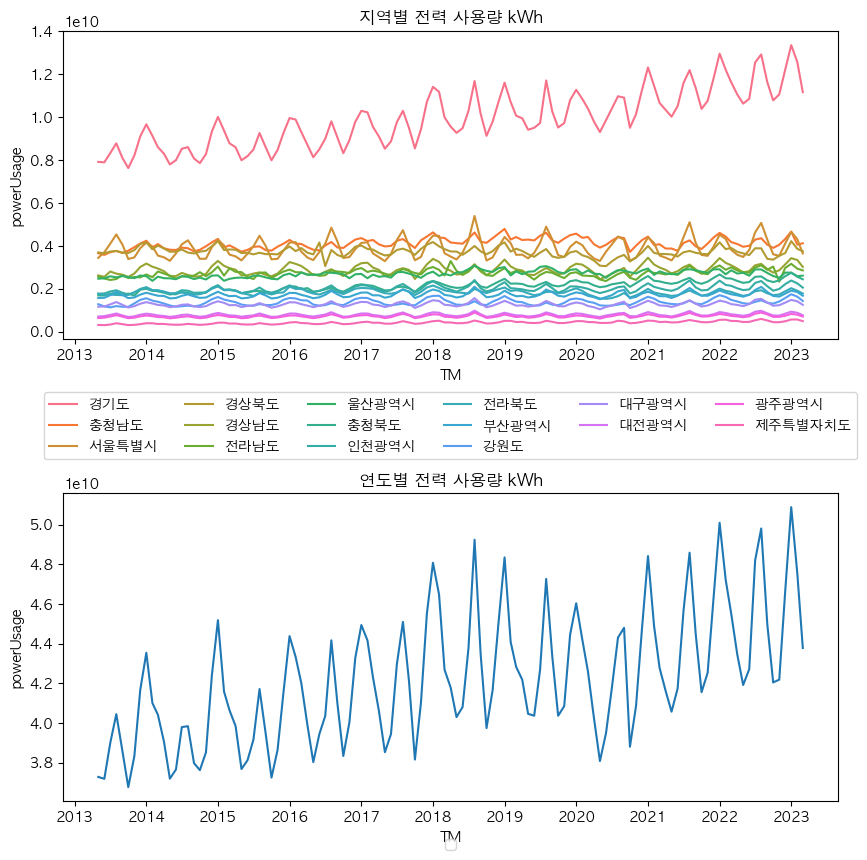

In [592]:
fig,axes = plt.subplots(2,1,figsize=(10,10))
plt.subplots_adjust(hspace=0.5)

dt_1m = power_demand_type_1m_metro.groupby(['metro','TM']).sum().reset_index()
dt_1m.drop(['city'],axis=1,inplace=True)

dt_order = dt_1m.groupby('metro').agg({'powerUsage':'sum'}).reset_index()
dt_order = dt_order.sort_values(by='powerUsage',ascending=False)
order = list(dt_order['metro'])

# plt.figure(figsize=(10,5))
# sns.lineplot(data=dt_1m,x='TM',y='powerUsage',hue='metro',legend='brief',hue_order=order)
# plt.legend(loc='upper center',bbox_to_anchor=(0.5,-0.1),ncol=6)
# plt.title('지역별 전력 사용량 kWh')
# plt.show()

sns.lineplot(data=dt_1m,x='TM',y='powerUsage',hue='metro',legend='brief',hue_order=order,ax=axes[0])
axes[0].legend(loc='upper center',bbox_to_anchor=(0.5,-0.15),ncol=6)
axes[0].set_title('지역별 전력 사용량 kWh')


dt_1m = power_demand_type_1m_metro.groupby(['TM']).sum().reset_index()
dt_1m.drop(['city'],axis=1,inplace=True)

sns.lineplot(data=dt_1m,x='TM',y='powerUsage',legend='brief',hue_order=order,ax=axes[1])
axes[1].legend(loc='upper center',bbox_to_anchor=(0.5,-0.1),ncol=6)
axes[1].set_title('연도별 전력 사용량 kWh')

plt.show()

In [625]:
data_power_demand_hour

,TM,p_demand_1h,year,month
0,2013-01-01 10:00:00,49572,2013,1
1,2013-01-02 10:00:00,70869,2013,1
2,2013-01-03 10:00:00,75999,2013,1
3,2013-01-04 10:00:00,76175,2013,1
4,2013-01-05 10:00:00,66806,2013,1
...,...,...,...,...
78883,2021-12-27 09:00:00,86054,2021,12
78884,2021-12-28 09:00:00,86809,2021,12
78885,2021-12-29 09:00:00,84106,2021,12
78886,2021-12-30 09:00:00,83494,2021,12


In [ ]:
# 연도별 라인그래프 작업중
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

dt_1m = power_demand_type_1m_metro.groupby(['metro','TM']).sum().reset_index()
dt_1m = dt_1m[dt_1m['metro']=='경기도'].sort_values(by='TM')
dt_1m['year'] = dt_1m['TM'].dt.year
dt_1m['month'] = dt_1m['TM'].dt.month
years = dt_1m.year.unique()
np.random.seed(42)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(16,12))
for i,y in enumerate(years):
    plt.plot('month', 'powerUsage', data=dt_1m, color=mycolors[i], label=y)
    plt.text(dt_1m[dt_1m.year==y].shape[0]-0.9, dt_1m.loc[dt_1m.year==y, 'powerUsage'][-1:].values[0], y, fontsize=12, color=mycolors[i])
    
plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel='test', xlabel='월')
# plt.yticks(fontsize=12, alpha=.7)
# plt.title("test", fontsize=20)
plt.show()



지역산업, 분야별 전기사용 비중

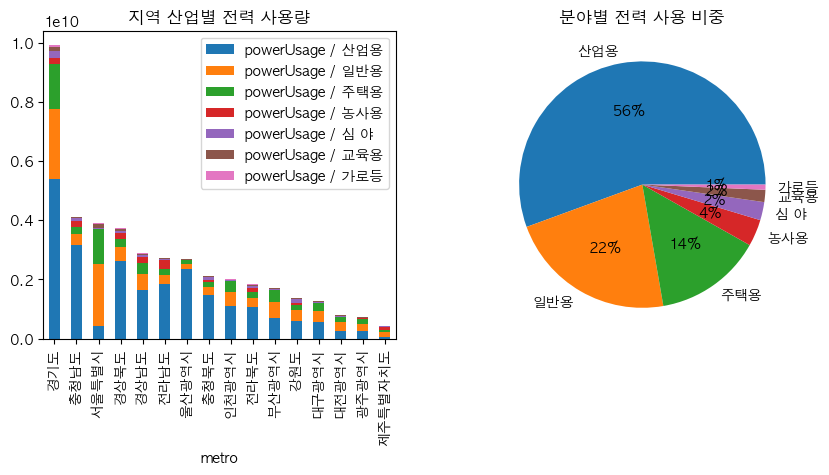

In [635]:
def flat_cols(df):
    df.columns = [' / '.join(x) for x in df.columns.to_flat_index()]
    return df

dt_1m = power_demand_type_1m_metro.groupby(['metro','TM','cntr']).sum().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

plt.subplots_adjust(hspace=1,wspace=0.2)

# 섭플랏 1
dt_1 = dt_1m[['metro','cntr','powerUsage']]
dt_1 = pd.pivot_table(data=dt_1,index='metro',columns='cntr').pipe(flat_cols)
dt_1 = dt_1.loc[:,dt_1.sum().sort_values(ascending=False).index]
dt_1.sort_index(ascending=False)
dt_1['sum'] = dt_1.sum(axis=1)
dt_1.sort_values(by='sum',ascending=False,inplace=True)
dt_1.drop(['sum'],axis=1,inplace=True)
dt_1.plot.bar(stacked=True, ax=ax1) # 스택바 섭플랏에 첨부
ax1.legend()
ax1.set_title('지역 산업별 전력 사용량')

# 섭플랏 2
dt_1m_by = dt_1m.groupby(['cntr']).agg({'powerUsage':'sum'}).reset_index().sort_values(by='powerUsage',ascending=False)
ax2.pie(data=dt_1m_by,labels=dt_1m_by['cntr'],x=dt_1m_by['powerUsage'],autopct='%1.f%%')
ax2.set_title('분야별 전력 사용 비중')

plt.show()


### 지역별 전기사용량 가중치 도출

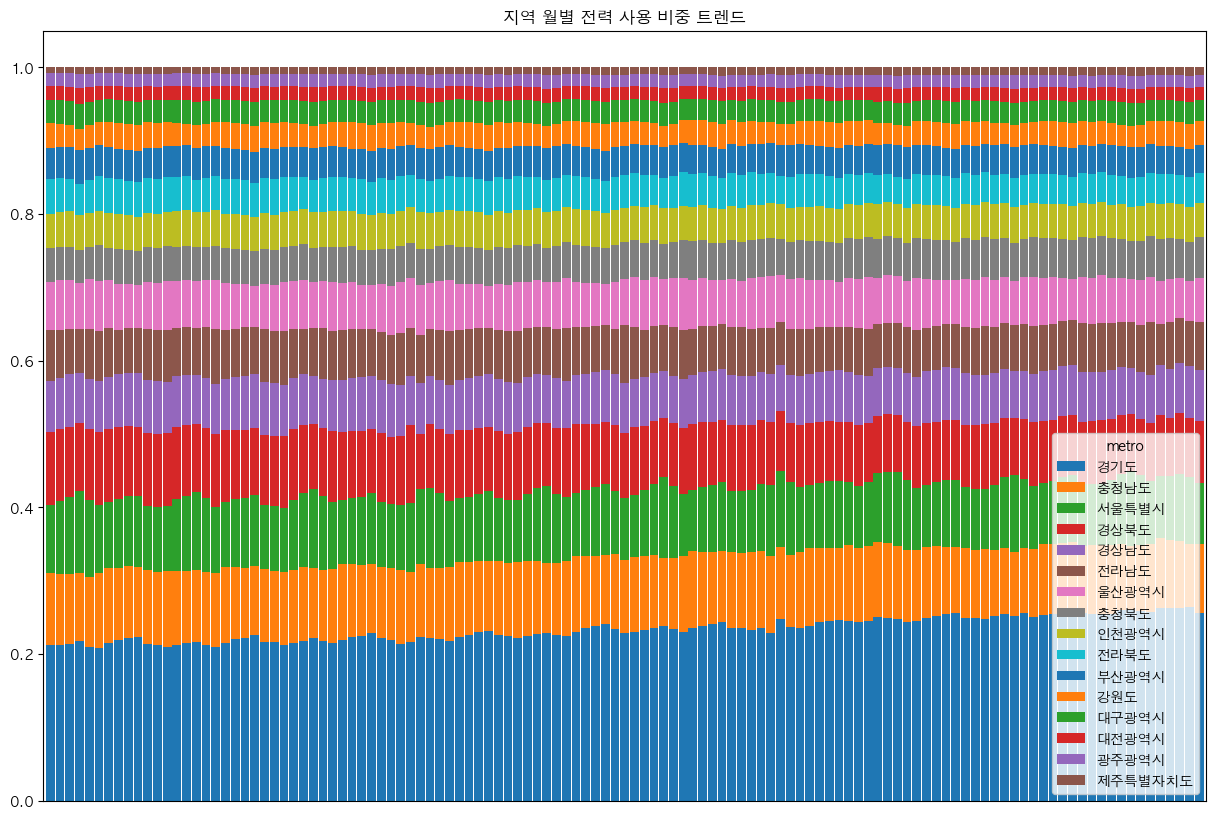

In [696]:
# 월별 지역별 전력 소모 비중 계산
df = dt_1m[['metro','TM','cntr','powerUsage']]
df = df.groupby(['metro','TM']).agg({'powerUsage':'sum'}).reset_index()

df = pd.pivot_table(data=df,index='TM',columns='metro')
df.columns = df.columns.droplevel(0)
df['total'] = df.sum(axis=1)
for col in df.columns:
    df[col] = df[col]/df['total']

df.drop('total',axis=1,inplace=True)

df = df.loc[:,df.sum().sort_values(ascending=False).index]
df.plot.bar(stacked=True,figsize=(15,10),width=0.9,xlabel='',xticks=[])
plt.title('지역 월별 전력 사용 비중 트렌드')
plt.show()



In [735]:
df_1 = df.reset_index()
df_1 = pd.pivot_table(data=df_1,index='TM').unstack().reset_index()
df_1['year'] = df_1['TM'].dt.year
df_1['month'] = df_1['TM'].dt.month
df_1.rename(columns={'metro':'도',0:'weight'},inplace=True)
df_1

,도,TM,weight,year,month
0,강원도,2013-05-01,0.034375,2013,5
1,강원도,2013-06-01,0.031713,2013,6
2,강원도,2013-07-01,0.029128,2013,7
3,강원도,2013-08-01,0.029474,2013,8
4,강원도,2013-09-01,0.030140,2013,9
...,...,...,...,...,...
1899,충청북도,2022-11-01,0.056642,2022,11
1900,충청북도,2022-12-01,0.055466,2022,12
1901,충청북도,2023-01-01,0.053999,2023,1
1902,충청북도,2023-02-01,0.053869,2023,2


In [754]:
weather_pv.head(1)

,TM,도,WS,PA,PS,TA,TD,HM,PV,RN,RN_DAY,SD_DAY,CA_TOT,CA_MID,CH_MIN,VS,SS,SI,TS,WH,year,month
0,2013-01-01,강원도,2.007692,992.623077,1021.476923,-10.407692,-16.2,65.230769,1.738462,0.0,0.0,0.0,1.384615,0.538462,1.769231,861.538462,0.0,0.0,-3.476923,0.076923,2013,1


가중평균 계산\
가중치의 랭킹의 월별 변화는 급격하지 않음. 따라서 월간 가중치를 각 시간대에 동일하게 부여
$$\hat{d} = \sum_{i=1}^{metros}w_i d_i$$

In [762]:
ww = pd.merge(weather_pv,df_1[['도','year','month','weight']],on=['도','year','month'],how='left')
ww = ww[(ww['TM']>'2013-05-01') & (ww['TM']<'2023-04-01')]
ww.drop(['year','month'],axis=1,inplace=True)

cols = ['WS', 'PA', 'PS', 'TA', 'TD', 'HM', 'PV', 'RN', 'RN_DAY',
       'SD_DAY', 'CA_TOT', 'CA_MID', 'CH_MIN', 'VS', 'SS', 'SI', 'TS', 'WH']

for col in cols:
       ww[col] = ww[col] * ww['weight']
ww.drop(['도'],axis=1,inplace=True)
ww = ww.groupby(['TM']).sum()
ww

,WS,PA,PS,TA,TD,HM,PV,RN,RN_DAY,SD_DAY,CA_TOT,CA_MID,CH_MIN,VS,SS,SI,TS,WH,weight
TM,,,,,,,,,,,,,,,,,,,
2013-05-01 01:00:00,2.347230,999.214295,1009.172448,9.710428,3.160941,65.581068,7.752144,0.003702,0.003702,0.0,0.079326,0.060817,0.044952,9.519174,0.000000,0.00000,8.434385,0.005288,1.0
2013-05-01 02:00:00,2.326152,999.271714,1009.259716,9.188318,3.216838,67.872077,7.755795,0.004231,0.007933,0.0,0.052884,0.042307,0.021154,6.081695,0.000000,0.00000,7.975433,0.000000,1.0
2013-05-01 03:00:00,2.254269,999.588286,1009.587204,8.749628,3.244882,69.738891,7.758868,0.002909,0.010841,0.0,1.190966,1.172457,1.761575,941.130526,0.000000,0.00000,7.664119,0.103626,1.0
2013-05-01 04:00:00,2.124747,999.764147,1009.774616,8.374307,3.255824,71.562430,7.755686,0.002644,0.013485,0.0,1.238221,1.225000,1.967413,927.505064,0.000000,0.00000,7.366779,0.103626,1.0
2013-05-01 05:00:00,2.100373,999.975202,1010.016084,8.020040,3.282154,73.236543,7.762669,0.002030,0.015516,0.0,1.620298,1.607077,2.843025,913.150526,0.000000,0.00000,7.209443,0.107168,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,2.070050,1007.036304,1016.511451,16.638311,0.924553,36.218401,6.683376,0.000000,0.006747,0.0,0.863959,0.060081,0.816521,1940.404107,0.219233,0.07621,14.174599,0.000000,1.0
2023-03-31 20:00:00,1.664232,1007.500910,1017.072860,14.860291,1.264072,41.307545,6.828344,0.000000,0.006747,0.0,0.231141,0.019812,0.756348,1807.428704,0.000000,0.00000,11.953256,0.000000,1.0
2023-03-31 21:00:00,1.388268,1007.877657,1017.534496,13.358766,1.638872,46.423450,6.979412,0.000000,0.006747,0.0,0.348762,0.000000,0.000000,1691.911383,0.000000,0.00000,10.512008,0.045547,1.0


In [719]:
# weather_pv['year'] = weather_pv.TM.dt.year
# weather_pv['month'] = weather_pv.TM.dt.month
weather_pv.groupby('도')

---

In [1]:
import pandas as pd

In [43]:
df1 = pd.read_pickle("./data/2023y_11w_1th_AWS.pkl")
df2 = pd.read_pickle("./data/2023y_11w_2th_AWS.pkl")
df3 = pd.read_pickle("./data/2023y_11w_3th_AWS.pkl")
df4 = pd.read_pickle("./data/2023y_11w_4th_AWS.pkl")
df5 = pd.read_pickle("./data/2023y_11w_5th_AWS.pkl")
df6 = pd.read_pickle("./data/2023y_11w_6th_AWS.pkl")
df7 = pd.read_pickle("./data/2023y_11w_7th_AWS.pkl")

weather_1m = pd.concat([df1, df2, df3, df4, df5, df6, df7])

In [4]:
weather_1m.columns[7:16]

Index(['TE0.05', 'TE0.1', 'TE0.2', 'TE0.3', 'TE0.5', 'TE1.0', 'TE1.5', 'TE3.0',
       'TE5.0'],
      dtype='object')

In [44]:
weather_1m = weather_1m.drop(columns=weather_1m.columns[7:16])

In [45]:
weather_1m[weather_1m.columns[1:]] = weather_1m[weather_1m.columns[1:]].astype(float)

In [46]:
weather_1m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046734 entries, 0 to 18715
Data columns (total 9 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   YYMMDDHHMI  1046734 non-null  datetime64[ns]
 1   STN         1046734 non-null  float64       
 2   TA          1046734 non-null  float64       
 3   HM          1046734 non-null  float64       
 4   TD          1046734 non-null  float64       
 5   TG          1046734 non-null  float64       
 6   TS          1046734 non-null  float64       
 7   PA          1046734 non-null  float64       
 8   PS          1046734 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 79.9 MB


In [41]:
weather_1m[(weather_1m[weather_1m.columns[2]] <= -50) |
           (weather_1m[weather_1m.columns[3]] <= -50) |
           (weather_1m[weather_1m.columns[4]] <= -50) |
           (weather_1m[weather_1m.columns[5]] <= -50) |
           (weather_1m[weather_1m.columns[6]] <= -50) |
           (weather_1m[weather_1m.columns[7]] <= -50) |
           (weather_1m[weather_1m.columns[8]] <= -50) 
           ]

,YYMMDDHHMI,STN,TA,HM,TD,TG,TS,PA,PS
97,2023-03-13 21:00:00,702.0,1.9,57.1,-5.7,-5.4,3.9,-99.7,-99.7
100,2023-03-13 21:00:00,974.0,1.5,73.6,-2.7,-99.7,2.2,-99.7,-99.7
101,2023-03-13 21:00:00,977.0,4.4,55.5,-3.7,1.6,3.3,-99.7,-99.7
102,2023-03-13 21:00:00,978.0,2.4,38.7,-10.3,-0.7,3.9,-99.7,-99.7
201,2023-03-13 21:01:00,702.0,1.9,57.9,-5.5,-5.4,3.9,-99.7,-99.7
...,...,...,...,...,...,...,...,...,...
18610,2023-03-19 02:58:00,978.0,3.4,62.0,-3.2,-2.3,2.2,-99.7,-99.7
18709,2023-03-19 02:59:00,702.0,1.3,76.7,-2.3,-5.0,3.0,-99.7,-99.7
18712,2023-03-19 02:59:00,974.0,2.9,70.2,-2.0,-99.7,1.9,-99.7,-99.7
18713,2023-03-19 02:59:00,977.0,0.6,87.8,-1.2,-2.4,1.9,-99.7,-99.7


In [ ]:
import os
import glob

path_dir = './processed_df/AWS_tmp/*.pkl'
file_list = glob.glob(path_dir)

file_list[0]

## 공통 전처리
tester = pd.read_pickle(file_list[500])
tester.drop(list(tester.iloc[:,7:16].columns),axis=1,inplace=True)
records_col = list(tester.iloc[:,2:].columns)
tester[records_col] = tester[records_col].astype(float)
tester['STN'] = tester['STN'].astype(int)
tester.sort_values(by='YYMMDDHHMI',inplace=True)
tester.reset_index(inplace=True,drop=True)
tester[records_col]

## nan처리
tmp = tester[records_col]
tmp[tmp<-90] = np.nan
tmp = pd.concat([tester[['YYMMDDHHMI','STN']],tmp],axis=1)


## 메타데이터 통합
tester_2 = tmp.merge(weather_meta_b,on='STN',how='left')

In [46]:
# 누락된 분 단위가 있는지 확인(ex. 2023-03-13 00:01 데이터가 아예 없는지 확인)

weather_1m_groupby_minutes = weather_1m.groupby("YYMMDDHHMI").count()
len(weather_1m_groupby_minutes)

10080

In [47]:
# max(각 분단위별 측정 사이트의 수)
weather_1m_groupby_minutes.max()

STN    104
TA     104
HM     104
TD     104
TG     104
TS     104
PA     104
PS     104
dtype: int64

In [48]:
weather_1m_groupby_minutes.min()

STN    23
TA     23
HM     23
TD     23
TG     23
TS     23
PA     23
PS     23
dtype: int64

In [45]:
weather_1m_groupby_minutes[weather_1m_groupby_minutes['count'] == 23]

,count
YYMMDDHHMI,
2023-03-13 17:11:00,23


In [10]:
weather_1m_groupby_minutes.loc["2023-03-13 17:05:00":"2023-03-13 17:16:00"]

,count
YYMMDDHHMI,
2023-03-13 17:05:00,104
2023-03-13 17:06:00,104
2023-03-13 17:07:00,104
2023-03-13 17:08:00,104
2023-03-13 17:09:00,103
2023-03-13 17:10:00,97
2023-03-13 17:11:00,23
2023-03-13 17:12:00,104
2023-03-13 17:13:00,104


In [11]:
weather_1m = weather_1m.set_index("YYMMDDHHMI")

In [12]:
print('',
weather_1m.loc["2023-03-13 17:10:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:11:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:12:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:13:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:14:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:15:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:16:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:17:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:18:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:19:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:20:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:21:00"]['TA'].mean(), '\n',
weather_1m.loc["2023-03-13 17:22:00"]['TA'].mean()
)

 7.965979381443299 
 7.865217391304348 
 7.957692307692308 
 7.9375 
 7.93076923076923 
 7.9163461538461535 
 7.898076923076924 
 7.865384615384615 
 7.8442307692307685 
 7.831067961165049 
 7.803883495145629 
 7.655319148936168 
 7.771844660194174


In [13]:
weather_1m_groupby_minutes.loc["2023-03-13 17:10:00":"2023-03-13 17:22:00"]

,count
YYMMDDHHMI,
2023-03-13 17:10:00,97
2023-03-13 17:11:00,23
2023-03-13 17:12:00,104
2023-03-13 17:13:00,104
2023-03-13 17:14:00,104
2023-03-13 17:15:00,104
2023-03-13 17:16:00,104
2023-03-13 17:17:00,104
2023-03-13 17:18:00,104


In [15]:
import numpy as np

In [16]:
print(
    np.mean(
        [weather_1m.loc["2023-03-13 17:01:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:02:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:03:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:04:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:05:00"]['TA'].mean()]
    ),
    np.mean(
        [weather_1m.loc["2023-03-13 17:06:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:07:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:08:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:09:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:10:00"]['TA'].mean()]
    ),
    np.mean(
        [weather_1m.loc["2023-03-13 17:11:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:12:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:13:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:14:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:15:00"]['TA'].mean()]
    ),
    
    np.mean(
        [weather_1m.loc["2023-03-13 17:16:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:17:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:18:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:19:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:20:00"]['TA'].mean()]
    ),
    np.mean(
        [weather_1m.loc["2023-03-13 17:21:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:22:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:23:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:24:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:25:00"]['TA'].mean()]
    ),
    np.mean(
        [weather_1m.loc["2023-03-13 17:26:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:27:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:28:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:29:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:30:00"]['TA'].mean()]
    ),
    np.mean(
        [weather_1m.loc["2023-03-13 17:31:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:32:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:33:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:34:00"]['TA'].mean(),
        weather_1m.loc["2023-03-13 17:35:00"]['TA'].mean()]
    )
)

8.080384615384615 8.018201477483581 7.921505016722408 7.848528752800597 7.73444767548384 7.709195817740404 7.617138009049775


In [17]:
weather_1m.columns

Index(['STN', 'TA', 'HM', 'TD', 'TG', 'TS', 'TE0.05', 'TE0.1', 'TE0.2',
       'TE0.3', 'TE0.5', 'TE1.0', 'TE1.5', 'TE3.0', 'TE5.0', 'PA', 'PS'],
      dtype='object')

In [47]:
weather_1m[weather_1m.columns[1:]] = weather_1m[weather_1m.columns[1:]].mask(weather_1m[weather_1m.columns[1:]] <= -50, np.nan)
weather_1m

,YYMMDDHHMI,STN,TA,HM,TD,TG,TS,PA,PS
0,2023-03-13 21:00:00,90.0,6.4,20.9,-14.4,4.4,3.5,1015.4,1017.6
1,2023-03-13 21:00:00,93.0,2.2,46.9,-8.0,0.2,2.0,1009.3,1021.3
2,2023-03-13 21:00:00,95.0,2.6,44.1,-8.4,0.6,2.9,1002.2,1021.6
3,2023-03-13 21:00:00,98.0,2.2,53.8,-6.2,0.4,3.0,1006.5,1021.0
4,2023-03-13 21:00:00,99.0,2.5,65.5,-3.3,1.0,2.5,1017.4,1021.2
...,...,...,...,...,...,...,...,...,...
18711,2023-03-19 02:59:00,973.0,-0.1,83.2,-2.6,-1.5,-0.4,1017.2,1022.2
18712,2023-03-19 02:59:00,974.0,2.9,70.2,-2.0,NaN,1.9,NaN,NaN
18713,2023-03-19 02:59:00,977.0,0.6,87.8,-1.2,-2.4,1.9,NaN,NaN
18714,2023-03-19 02:59:00,978.0,3.3,62.1,-3.3,-2.2,2.2,NaN,NaN


In [51]:
weather_1m.groupby('STN').count().sort_index().head(60) -10079

,YYMMDDHHMI,TA,HM,TD,TG,TS,PA,PS
STN,,,,,,,,
90.0,0,0,0,0,0,0,0,0
93.0,-4,-4,-4,-4,-4,-4,-4,-4
95.0,-4,-4,-4,-4,-4,-4,-4,-4
98.0,-4,-4,-4,-4,-4,-4,-4,-4
99.0,-4,-4,-4,-4,-4,-4,-4,-4
100.0,-7,-7,-7,-7,-7,-7,-7,-7
101.0,-4,-4,-4,-4,-4,-4,-4,-4
102.0,-4,-4,-4,-4,-4,-4,-4,-4
104.0,0,0,-8,-8,0,0,0,0


In [52]:
weather_1m.groupby('STN').count().sort_index().tail(60) - 10079

,YYMMDDHHMI,TA,HM,TD,TG,TS,PA,PS
STN,,,,,,,,
189.0,-3,-3,-3,-3,-3,-3,-3,-3
192.0,-4,-10,-4,-10,-4,-4,-4,-10
201.0,-4,-4,-4,-4,-4,-4,-4,-4
202.0,-12,-12,-243,-243,-12,-12,-12,-12
203.0,-4,-4,-4,-4,-4,-4,-4,-4
211.0,-4,-4,-4,-4,-4,-4,-4,-4
212.0,-4,-4,-4,-4,-4,-4,-4,-4
216.0,0,0,0,0,0,0,0,0
217.0,-20,-167,-4580,-4659,-20,-20,-21,-168


In [69]:
weather_1m['STN'].unique()

array([ 90.,  93.,  95.,  98.,  99., 100., 101., 102., 104., 105., 106.,
       108., 112., 114., 115., 119., 121., 127., 129., 130., 131., 133.,
       135., 136., 137., 138., 140., 143., 146., 152., 155., 156., 159.,
       162., 165., 168., 169., 170., 172., 174., 177., 184., 185., 188.,
       189., 192., 201., 202., 203., 211., 212., 216., 217., 221., 226.,
       232., 235., 236., 238., 239., 243., 244., 245., 247., 248., 251.,
       252., 253., 254., 255., 257., 258., 259., 260., 261., 262., 263.,
       264., 266., 268., 271., 272., 273., 276., 277., 278., 279., 281.,
       283., 284., 285., 288., 289., 294., 295., 296., 676., 702., 972.,
       973., 974., 977., 978., 980.])

In [71]:
weather_1m['YYMMDDHHMI'].min(), weather_1m['YYMMDDHHMI'].max()

(Timestamp('2023-03-13 00:00:00'), Timestamp('2023-03-19 23:59:00'))

In [48]:
new_index = pd.MultiIndex.from_product([
    pd.date_range(start='2023-03-13 00:00:00', end='2023-03-19 23:59:00', freq='T'),
    weather_1m['STN'].unique()
], names=['YYMMDDHHMI', 'STN'])

In [98]:
new_index

MultiIndex([('2023-03-13 00:00:00',  90.0),
            ('2023-03-13 00:00:00',  93.0),
            ('2023-03-13 00:00:00',  95.0),
            ('2023-03-13 00:00:00',  98.0),
            ('2023-03-13 00:00:00',  99.0),
            ('2023-03-13 00:00:00', 100.0),
            ('2023-03-13 00:00:00', 101.0),
            ('2023-03-13 00:00:00', 102.0),
            ('2023-03-13 00:00:00', 104.0),
            ('2023-03-13 00:00:00', 105.0),
            ...
            ('2023-03-19 23:59:00', 295.0),
            ('2023-03-19 23:59:00', 296.0),
            ('2023-03-19 23:59:00', 676.0),
            ('2023-03-19 23:59:00', 702.0),
            ('2023-03-19 23:59:00', 972.0),
            ('2023-03-19 23:59:00', 973.0),
            ('2023-03-19 23:59:00', 974.0),
            ('2023-03-19 23:59:00', 977.0),
            ('2023-03-19 23:59:00', 978.0),
            ('2023-03-19 23:59:00', 980.0)],
           names=['YYMMDDHHMI', 'STN'], length=1048320)

In [49]:
weather_1m = weather_1m.sort_values(["YYMMDDHHMI", "STN"]).set_index(["YYMMDDHHMI", "STN"])
weather_1m = weather_1m.reindex(new_index, fill_value=np.nan)

In [50]:
weather_1h['datetime'] = pd.to_datetime(weather_1h['datetime'])
weather_1h = weather_1h[['datetime', 'STN_ID', 'TA_C', 'HM_%', 'TD_C', 'TS_C', 'PA_hPa', 'PS_hPa']]
weather_1h = weather_1h.rename(columns={'STN_ID':'STN'}).set_index(['datetime'])
weather_1h = weather_1h.loc['2023-03-13':'2023-03-19']
weather_1h

,STN,TA_C,HM_%,TD_C,TS_C,PA_hPa,PS_hPa
datetime,,,,,,,
2023-03-13 00:00:00,90,0.5,43.0,-10.6,1.1,1015.3,1017.5
2023-03-13 00:00:00,93,-0.1,35.0,-13.7,-0.4,1010.4,1022.5
2023-03-13 00:00:00,95,-1.1,41.0,-12.7,-0.2,1003.8,1023.5
2023-03-13 00:00:00,98,-1.3,53.0,-9.6,-0.3,1009.0,1023.7
2023-03-13 00:00:00,99,-0.2,39.0,-12.5,-0.5,1020.8,1024.7
...,...,...,...,...,...,...,...
2023-03-19 23:00:00,288,6.9,56.0,-1.2,5.7,1017.5,1018.5
2023-03-19 23:00:00,289,6.6,58.0,-1.0,1.0,1002.7,1019.7
2023-03-19 23:00:00,294,10.0,69.0,4.5,7.4,1013.6,1019.1


In [51]:
weather_1m = weather_1m.reset_index().set_index('YYMMDDHHMI')
weather_1m

,STN,TA,HM,TD,TG,TS,PA,PS
YYMMDDHHMI,,,,,,,,
2023-03-13 00:00:00,90.0,0.5,43.3,-10.6,-1.0,1.1,1015.3,1017.5
2023-03-13 00:00:00,93.0,-0.1,34.8,-13.8,-1.7,-0.4,1010.4,1022.5
2023-03-13 00:00:00,95.0,-1.1,40.9,-12.7,-2.7,-0.2,1003.8,1023.5
2023-03-13 00:00:00,98.0,-1.3,53.2,-9.6,-3.5,-0.3,1009.0,1023.7
2023-03-13 00:00:00,99.0,-0.2,39.1,-12.5,-1.3,-0.5,1020.8,1024.7
...,...,...,...,...,...,...,...,...
2023-03-19 23:59:00,973.0,2.9,87.8,1.1,1.4,2.3,1014.9,1019.9
2023-03-19 23:59:00,974.0,2.2,75.5,-1.7,NaN,3.1,NaN,NaN
2023-03-19 23:59:00,977.0,1.9,73.7,-2.3,-3.5,2.6,NaN,NaN


In [52]:
weather_1m.columns.drop('TG')

Index(['STN', 'TA', 'HM', 'TD', 'TS', 'PA', 'PS'], dtype='object')

In [53]:
weather_1h.columns

Index(['STN', 'TA_C', 'HM_%', 'TD_C', 'TS_C', 'PA_hPa', 'PS_hPa'], dtype='object')

In [54]:
weather_1h = weather_1h.rename(columns=dict(zip(weather_1h.columns, weather_1m.columns.drop('TG'))))
weather_1h

,STN,TA,HM,TD,TS,PA,PS
datetime,,,,,,,
2023-03-13 00:00:00,90,0.5,43.0,-10.6,1.1,1015.3,1017.5
2023-03-13 00:00:00,93,-0.1,35.0,-13.7,-0.4,1010.4,1022.5
2023-03-13 00:00:00,95,-1.1,41.0,-12.7,-0.2,1003.8,1023.5
2023-03-13 00:00:00,98,-1.3,53.0,-9.6,-0.3,1009.0,1023.7
2023-03-13 00:00:00,99,-0.2,39.0,-12.5,-0.5,1020.8,1024.7
...,...,...,...,...,...,...,...
2023-03-19 23:00:00,288,6.9,56.0,-1.2,5.7,1017.5,1018.5
2023-03-19 23:00:00,289,6.6,58.0,-1.0,1.0,1002.7,1019.7
2023-03-19 23:00:00,294,10.0,69.0,4.5,7.4,1013.6,1019.1


In [57]:
new_index = pd.MultiIndex.from_product([
    pd.date_range(start='2023-03-13 00:00:00', end='2023-03-19 23:59:00', freq='T'),
    weather_1m['STN'].unique()
], names=['YYMMDDHHMI', 'STN'])

In [59]:
weather_1h = weather_1h.reset_index().set_index(['YYMMDDHHMI', 'STN']).reindex(new_index, fill_value=np.nan)

In [60]:
weather_1h = weather_1h.reset_index().set_index(['STN', 'YYMMDDHHMI'])

In [63]:
weather_1h = weather_1h.sort_values(['STN', 'YYMMDDHHMI'])

In [64]:
weather_1h[weather_1h.columns[0:]] = weather_1h[weather_1h.columns[0:]].interpolate(method='linear')

In [63]:
import matplotlib.pyplot as plt

In [66]:
weather_1h

TA         HM         TD        TS  \
STN   YYMMDDHHMI                                                      
90.0  2023-03-13 00:00:00  0.500000  43.000000 -10.600000  1.100000   
      2023-03-13 00:01:00  0.491667  42.816667 -10.668333  1.091667   
      2023-03-13 00:02:00  0.483333  42.633333 -10.736667  1.083333   
      2023-03-13 00:03:00  0.475000  42.450000 -10.805000  1.075000   
      2023-03-13 00:04:00  0.466667  42.266667 -10.873333  1.066667   
...                             ...        ...        ...       ...   
980.0 2023-03-19 23:55:00  7.300000  65.000000   1.100000  5.100000   
      2023-03-19 23:56:00  7.300000  65.000000   1.100000  5.100000   
      2023-03-19 23:57:00  7.300000  65.000000   1.100000  5.100000   
      2023-03-19 23:58:00  7.300000  65.000000   1.100000  5.100000   
      2023-03-19 23:59:00  7.300000  65.000000   1.100000  5.100000   

                                    PA           PS  
STN   YYMMDDHHMI                                     
90.0  2023-03-13 00:00:00  1015.300000  1017.500000  
      2023-03-13 00:01:00  1015.321667  1017.521667  
      2023-03-13 00:02:00  1015.343333  1017.543333  
      2023-03-13 00:03:00  1015.365000  1017.565000  
      2023-03-13 00:04:00  1015.386667  1017.586667  
...                                ...          ...  
980.0 2023-03-19 23:55:00  1019.200000  1019.600000  
      2023-03-19 23:56:00  1019.200000  1019.600000  
      2023-03-19 23:57:00  1019.200000  1019.600000  
      2023-03-19 23:58:00  1019.200000  1019.600000  
      2023-03-19 23:59:00  1019.200000  1019.600000  

[1048320 rows x 6 columns]

In [68]:
weather_1h = weather_1h.reset_index().set_index("YYMMDDHHMI")

In [69]:
weather_1h

,STN,TA,HM,TD,TS,PA,PS
YYMMDDHHMI,,,,,,,
2023-03-13 00:00:00,90.0,0.500000,43.000000,-10.600000,1.100000,1015.300000,1017.500000
2023-03-13 00:01:00,90.0,0.491667,42.816667,-10.668333,1.091667,1015.321667,1017.521667
2023-03-13 00:02:00,90.0,0.483333,42.633333,-10.736667,1.083333,1015.343333,1017.543333
2023-03-13 00:03:00,90.0,0.475000,42.450000,-10.805000,1.075000,1015.365000,1017.565000
2023-03-13 00:04:00,90.0,0.466667,42.266667,-10.873333,1.066667,1015.386667,1017.586667
...,...,...,...,...,...,...,...
2023-03-19 23:55:00,980.0,7.300000,65.000000,1.100000,5.100000,1019.200000,1019.600000
2023-03-19 23:56:00,980.0,7.300000,65.000000,1.100000,5.100000,1019.200000,1019.600000
2023-03-19 23:57:00,980.0,7.300000,65.000000,1.100000,5.100000,1019.200000,1019.600000


In [70]:
weather_1h = weather_1h.reset_index().set_index(['YYMMDDHHMI', 'STN'])
weather_1m = weather_1m.reset_index().set_index(['YYMMDDHHMI', 'STN'])

In [98]:
weather_1h.columns

Index(['TA', 'HM', 'TD', 'TS', 'PA', 'PS'], dtype='object')

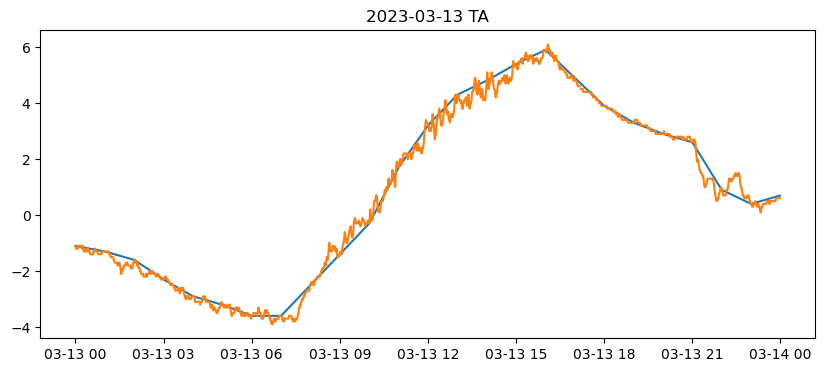

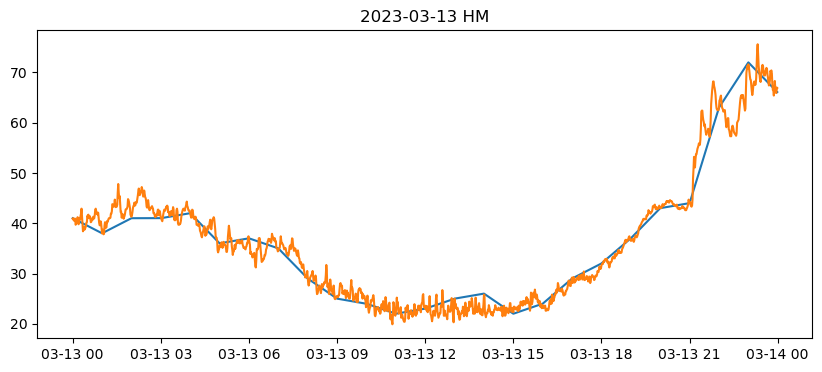

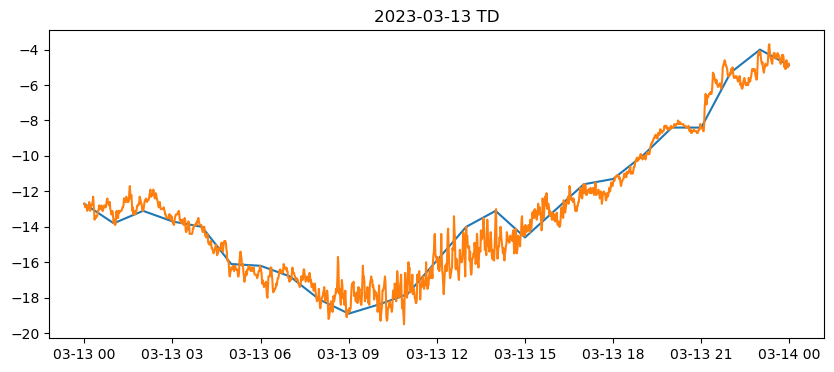

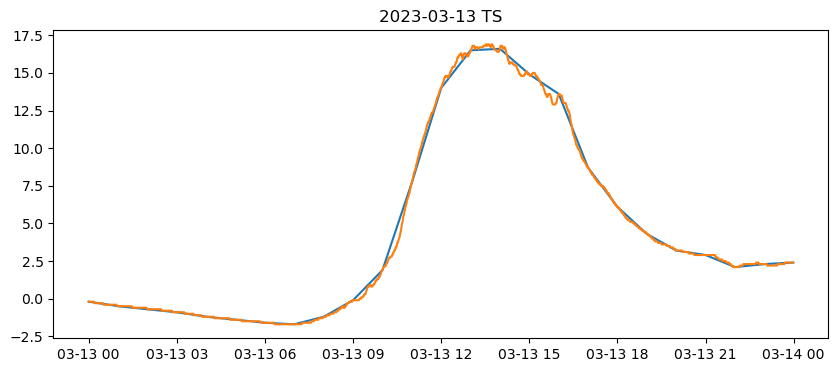

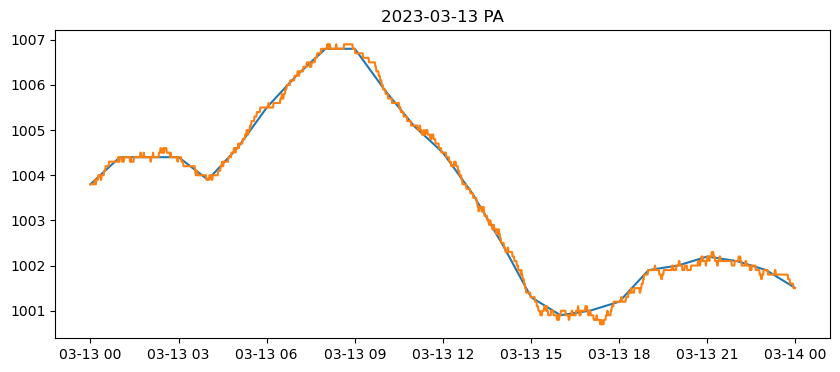

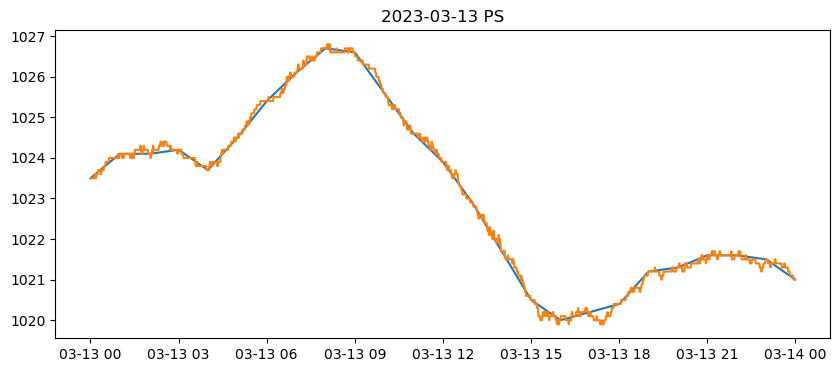

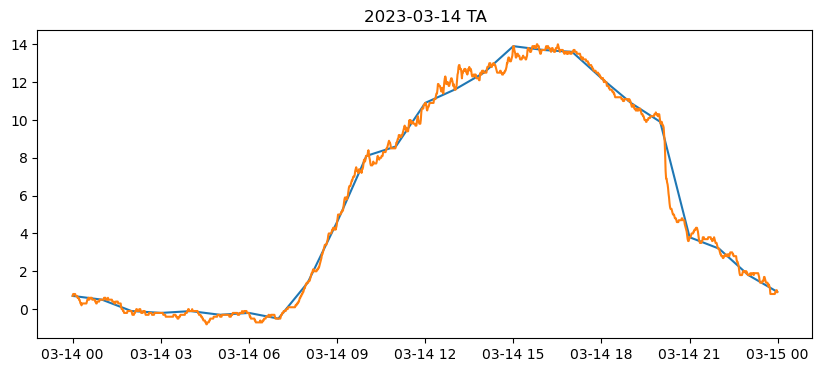

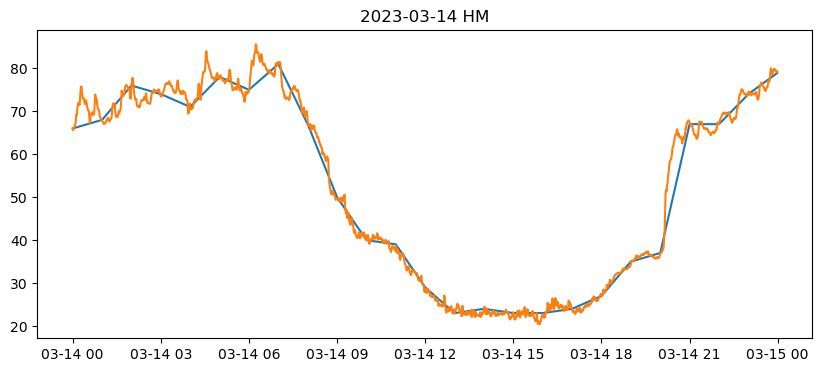

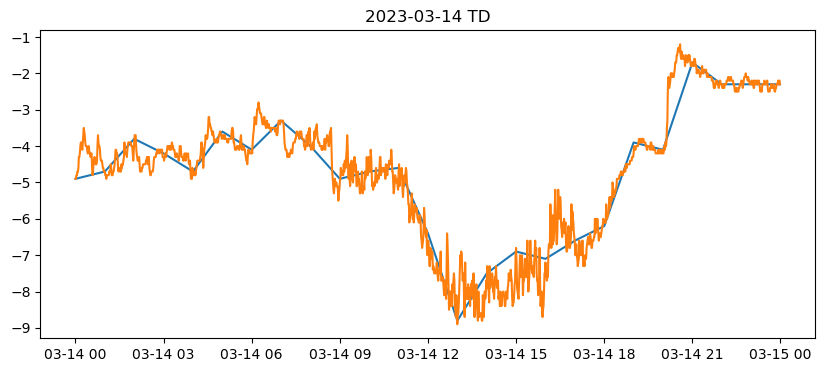

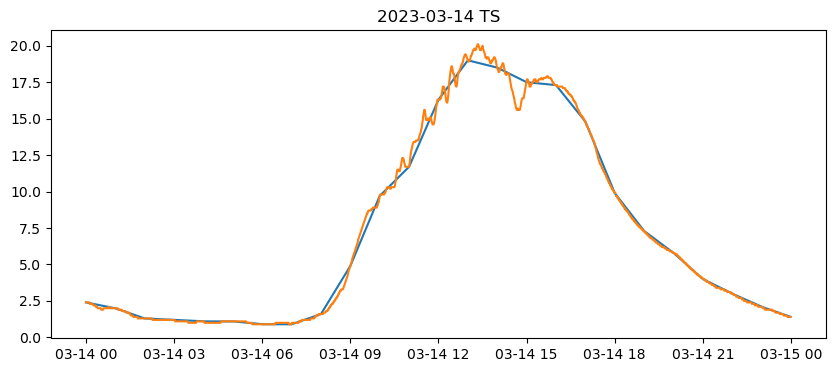

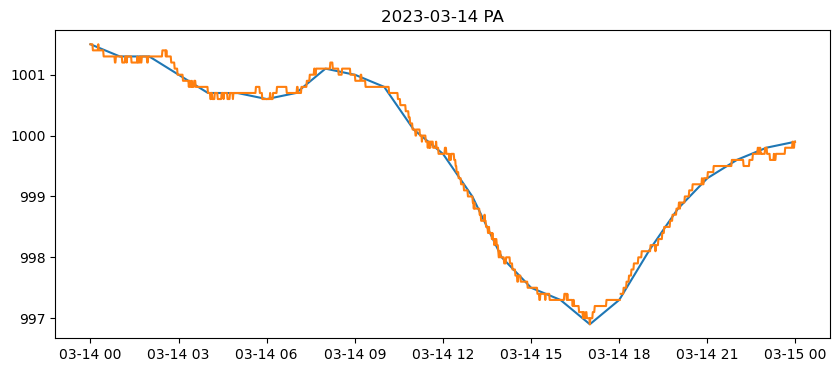

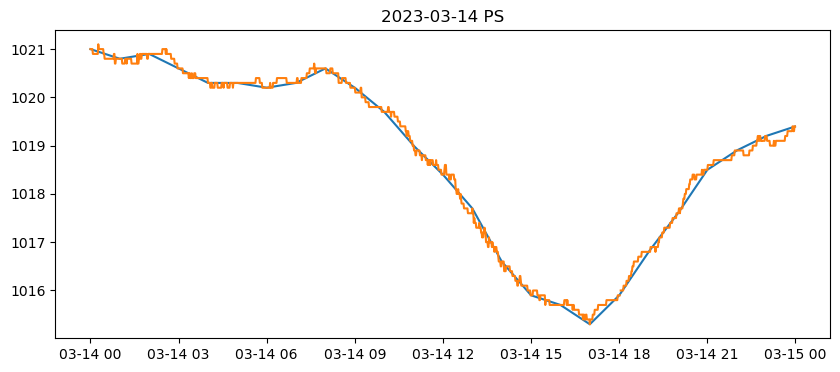

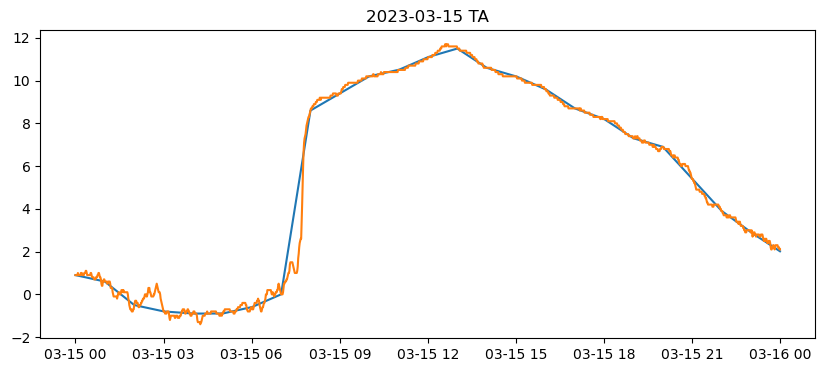

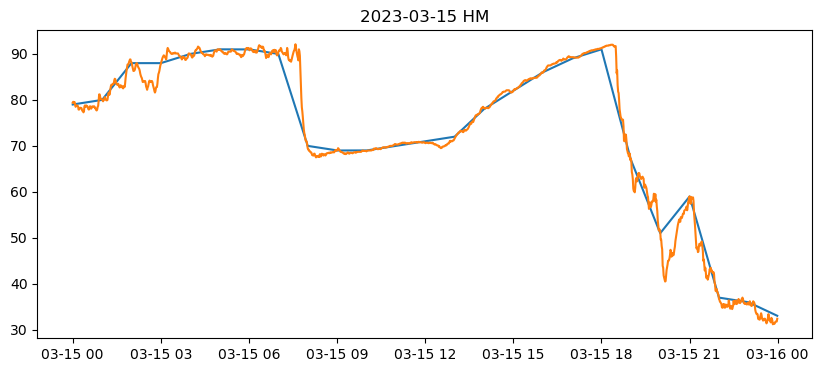

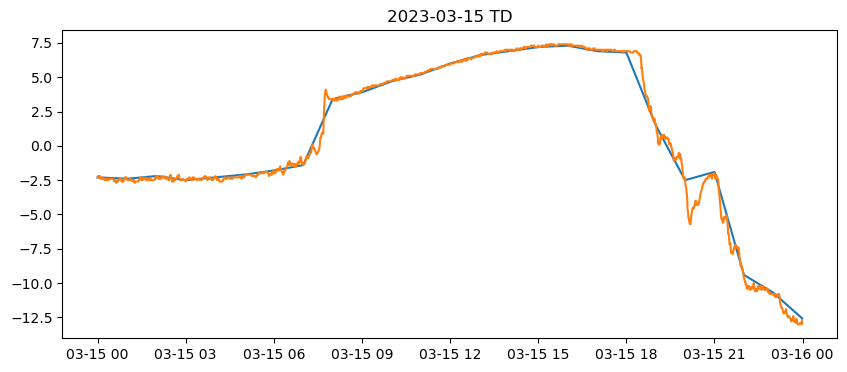

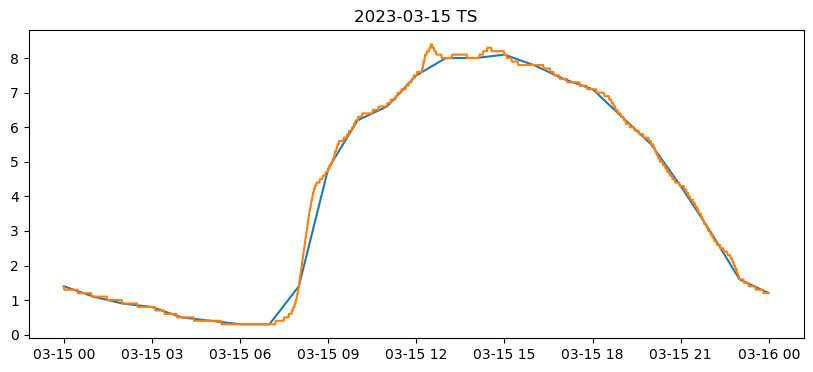

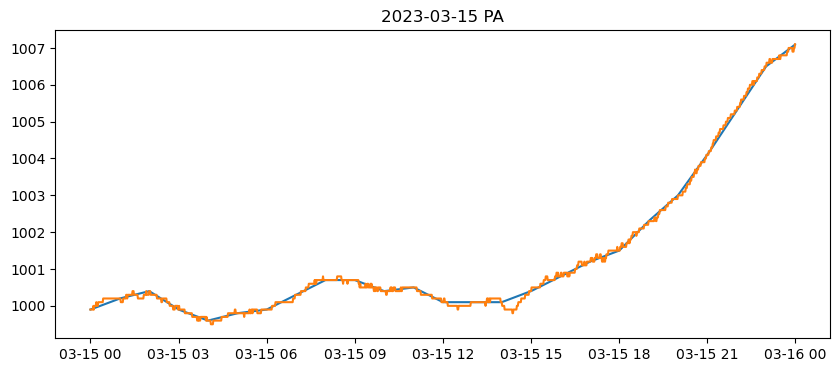

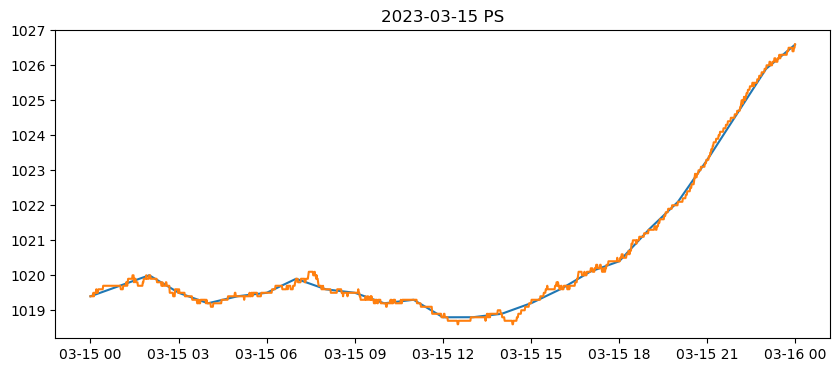

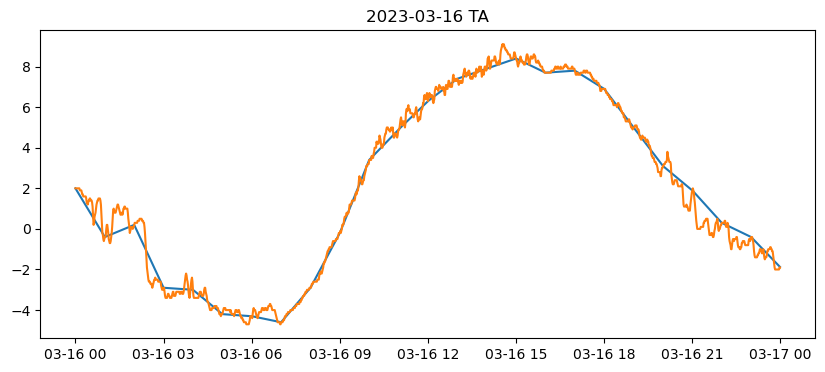

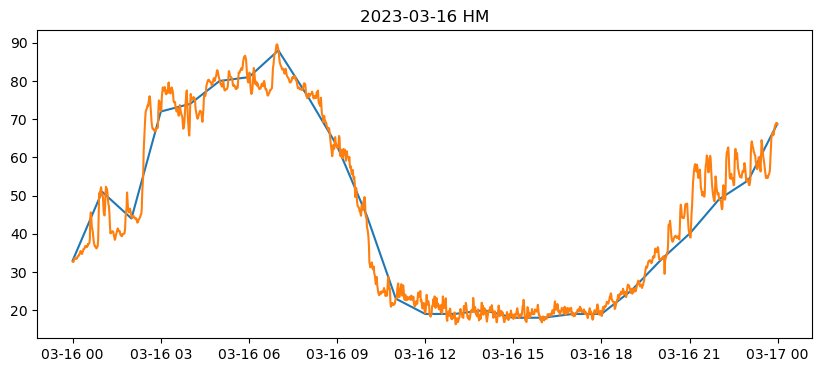

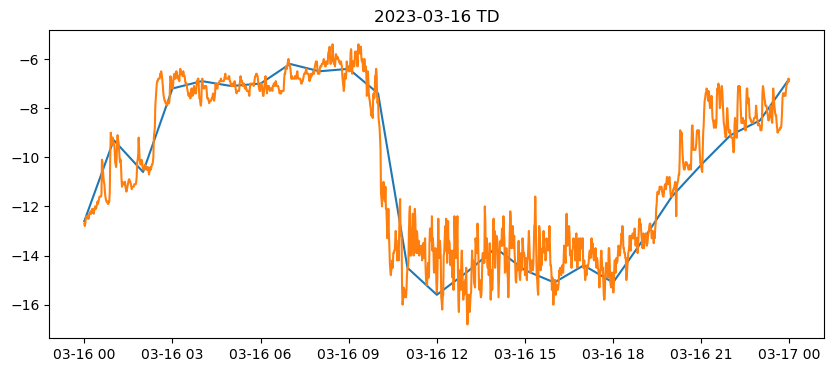

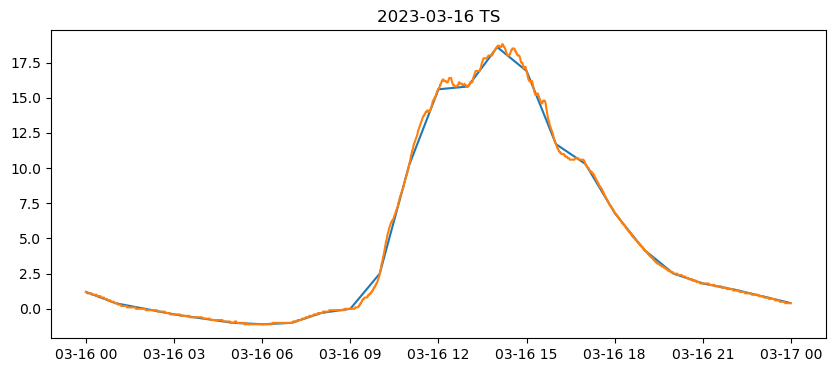

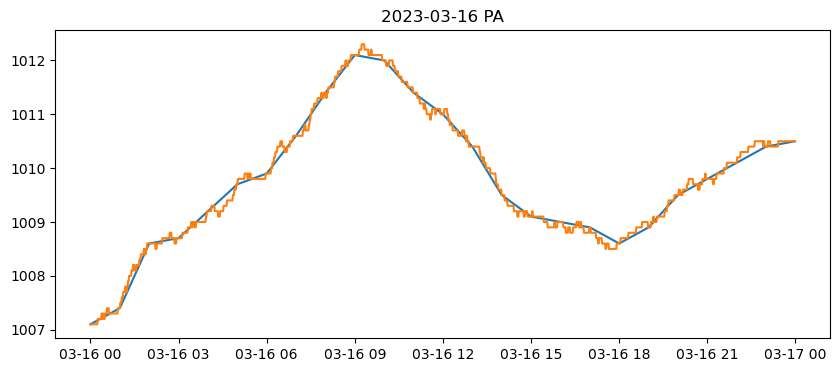

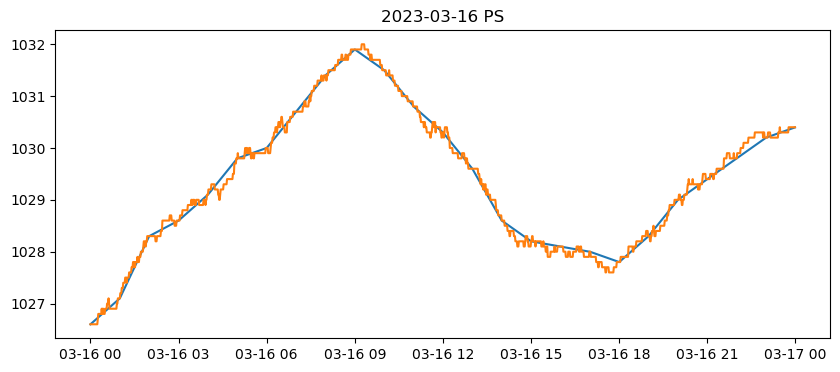

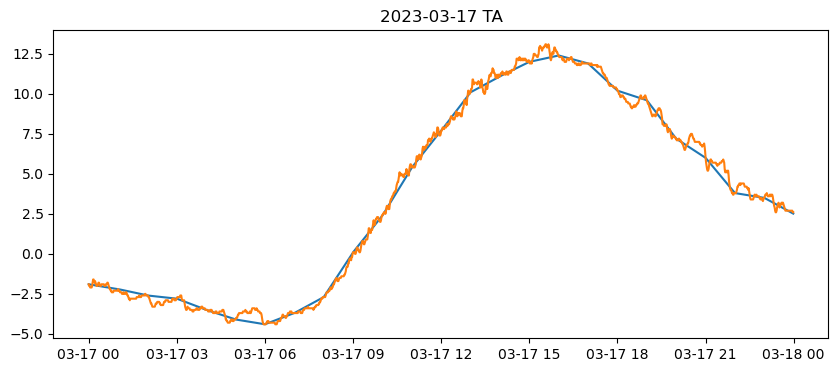

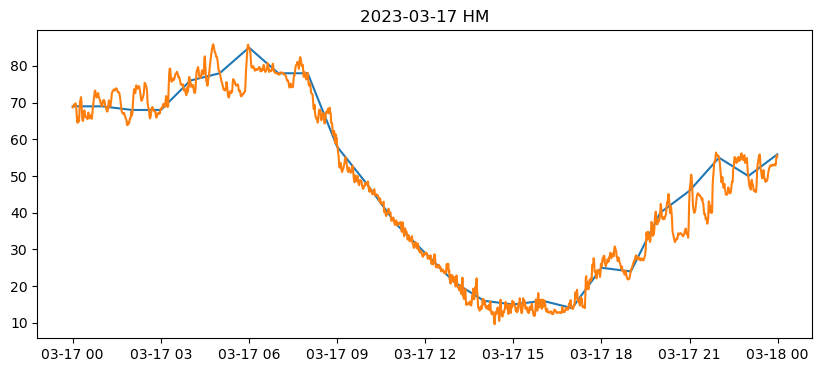

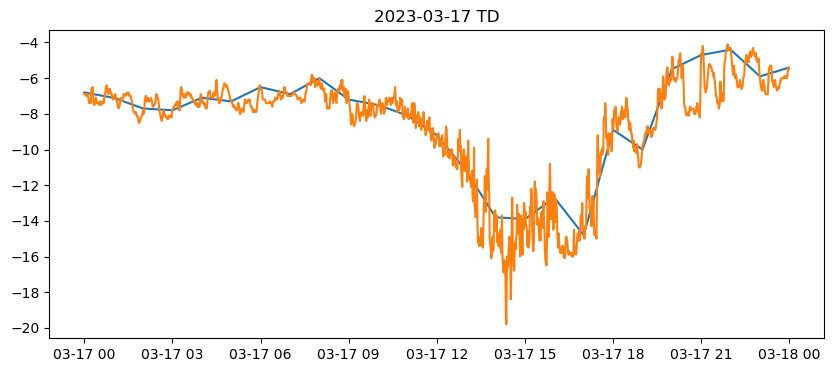

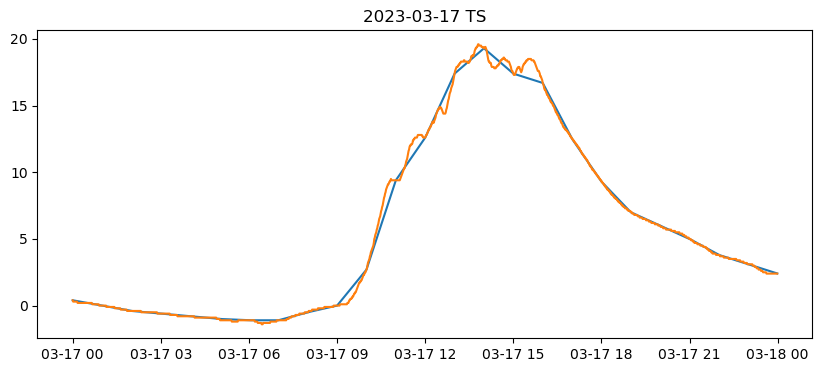

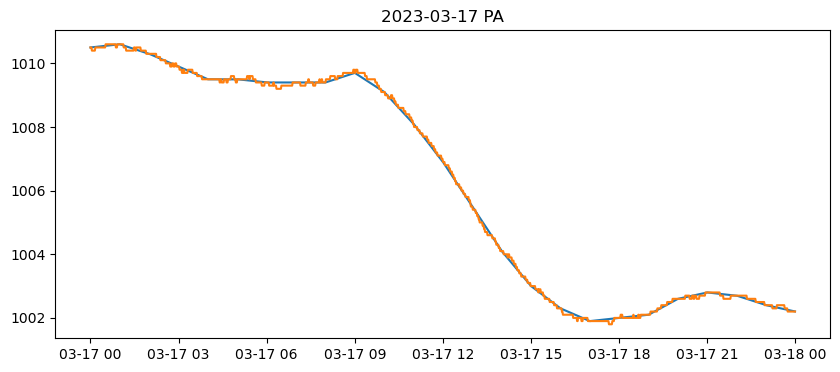

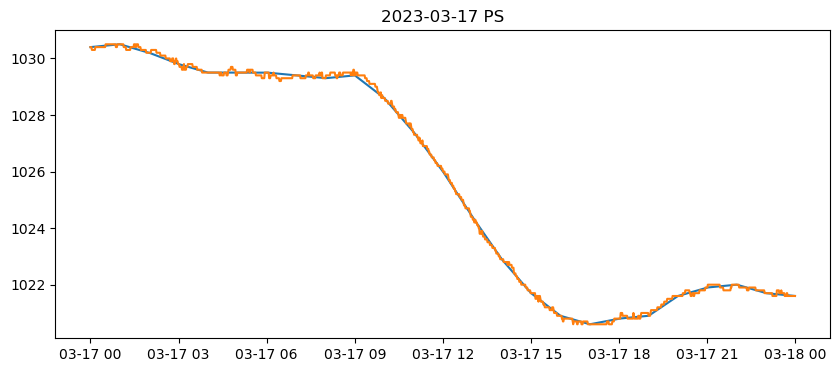

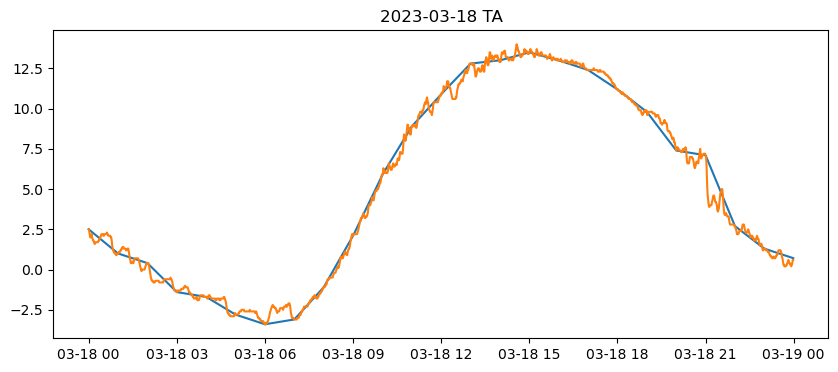

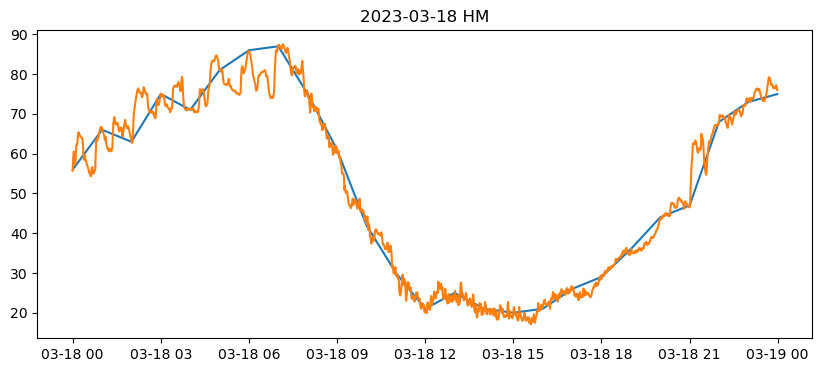

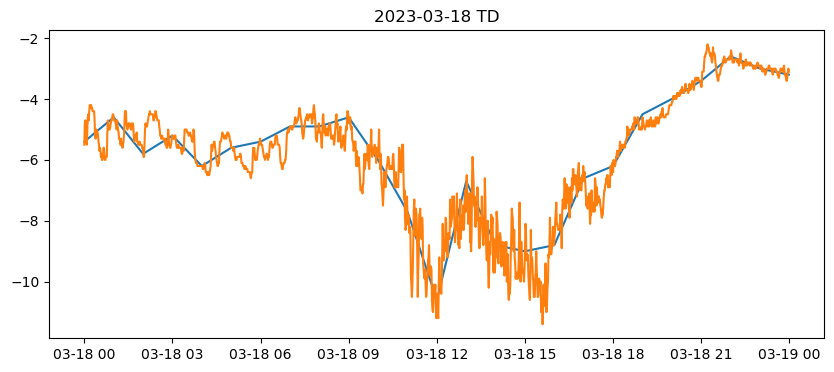

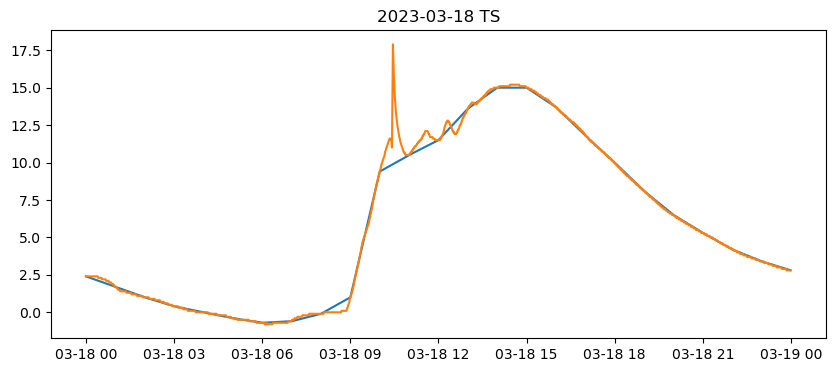

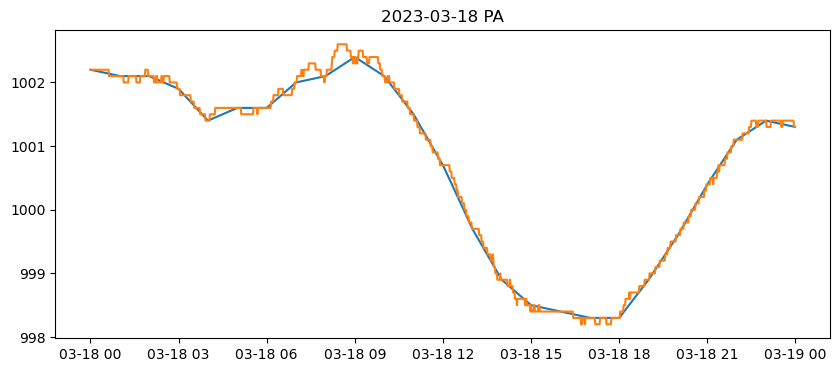

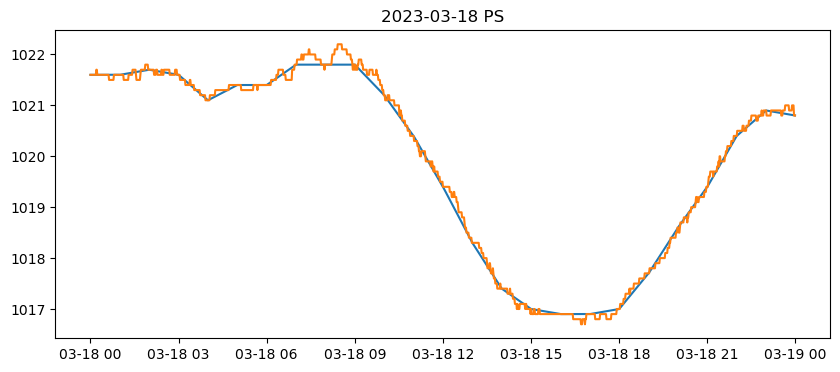

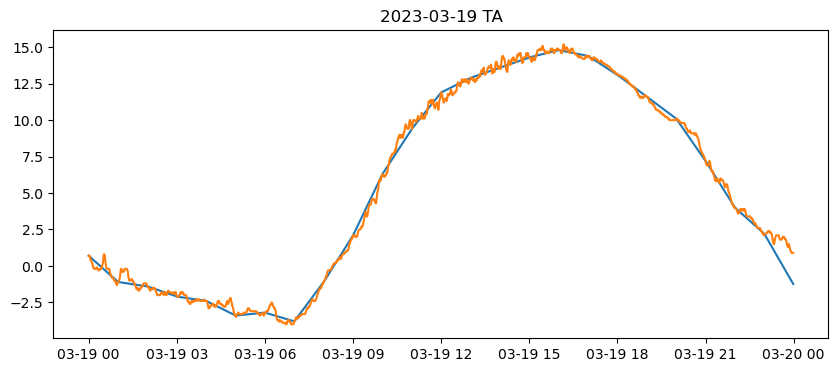

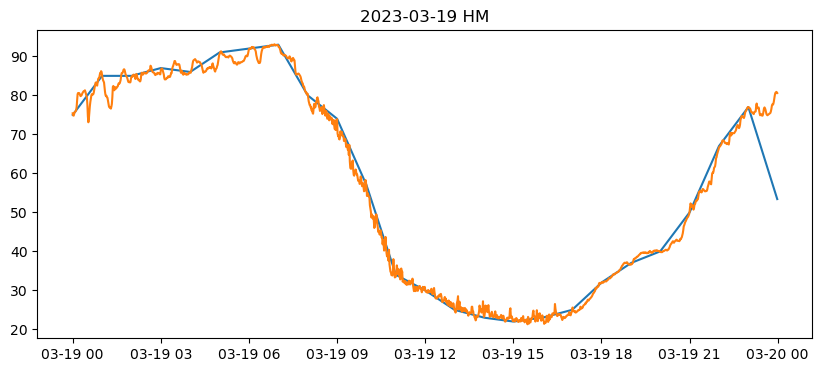

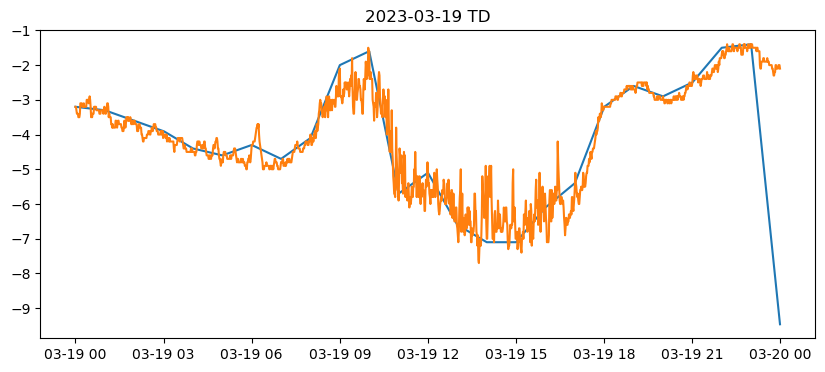

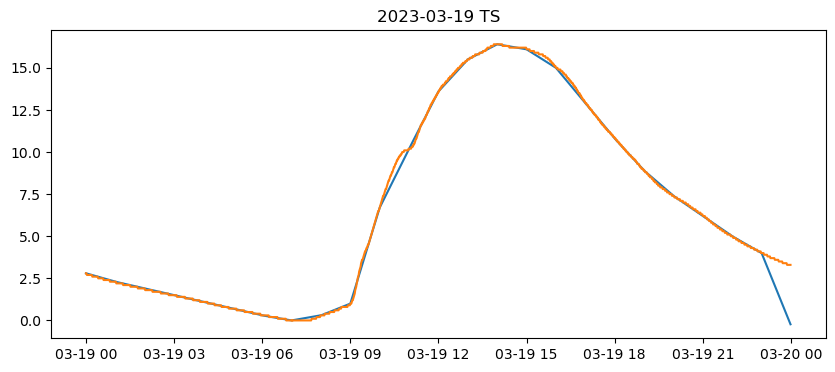

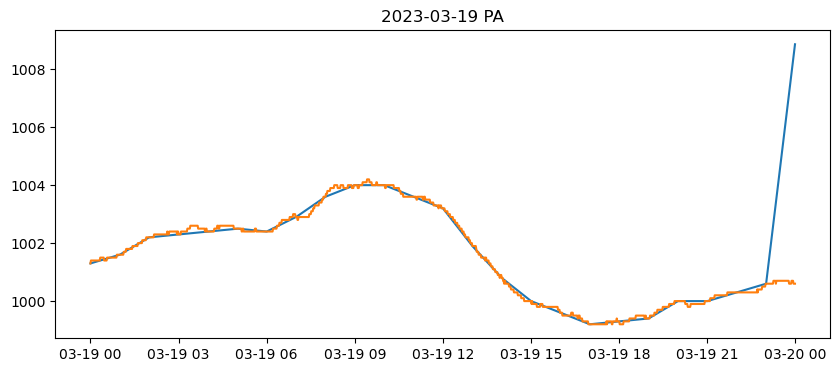

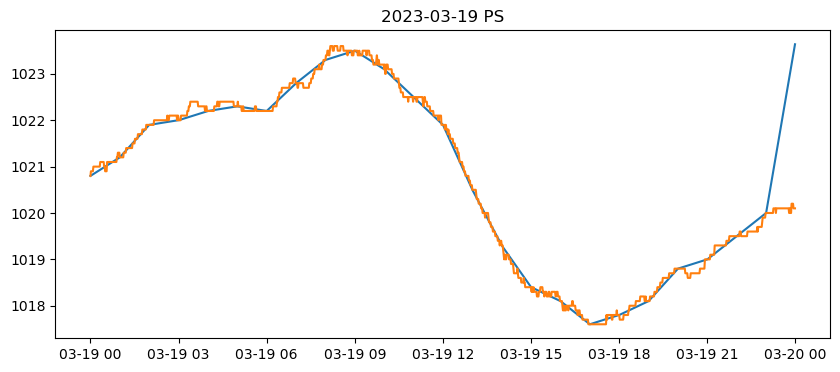

In [71]:
for date in ['2023-03-13', '2023-03-14', '2023-03-15', '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19']:
    for col in weather_1h.columns:
        plt.figure(figsize=(10, 4))
        plt.title(date+ ' ' +str(col))
        plt.plot(weather_1h.loc[(date, 95), col])
        plt.plot(weather_1m.loc[(date, 95), col])
        plt.show()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_5m = pd.read_parquet('./data/5m.parquet')

In [3]:
df_5m = df_5m.drop(columns='도').groupby('YYMMDDHHMI').mean().sort_index()

In [4]:
power_demand = pd.read_csv('./data/power_demand_interpolated.csv')
power_demand['기준일시'] = pd.to_datetime(power_demand['기준일시'])
power_demand = power_demand.set_index('기준일시')
power_demand

,현재수요(MW)
기준일시,
2012-06-01 00:00:00,51726.33
2012-06-01 00:05:00,51342.53
2012-06-01 00:10:00,51583.17
2012-06-01 00:15:00,51631.69
2012-06-01 00:20:00,51252.66
...,...
2023-03-20 23:35:00,64475.60
2023-03-20 23:40:00,64211.80
2023-03-20 23:45:00,63576.80


In [5]:
df_5m['PW'] = power_demand['현재수요(MW)']
df_5m

,TA,HM,TD,TG,TS,PA,PS,PW
YYMMDDHHMI,,,,,,,,
2021-03-01 00:00:00,9.001464,78.632205,5.199091,7.657828,7.330375,1011.879843,1022.391176,56471.5
2021-03-01 00:05:00,9.004489,78.450145,5.164567,7.658628,7.324188,1011.819146,1022.329908,56166.9
2021-03-01 00:10:00,8.998369,78.561007,5.179114,7.690317,7.328757,1011.760322,1022.273106,56051.1
2021-03-01 00:15:00,9.027408,78.524590,5.195527,7.724583,7.327065,1011.709552,1022.220409,55489.8
2021-03-01 00:20:00,9.043698,78.469933,5.199459,7.710900,7.317312,1011.665123,1022.174109,55180.9
...,...,...,...,...,...,...,...,...
2023-03-19 23:35:00,5.497090,66.670551,-0.632887,1.347978,3.990400,1008.396930,1018.887681,58627.2
2023-03-19 23:40:00,5.435557,66.709566,-0.691990,1.301644,3.946908,1008.370549,1018.867384,57941.2
2023-03-19 23:45:00,5.378361,66.847333,-0.719847,1.137594,3.865909,1008.351255,1018.852022,57726.2


In [6]:
from datetime import datetime, timedelta

In [42]:
def get_dates(start_date, end_date):
    delta = timedelta(days=1)
    result = []
    while start_date <= end_date:
        result.append(start_date)
        start_date += delta
    return result

start_date = datetime.strptime('2021-03-01', '%Y-%m-%d').date()
end_date = datetime.strptime('2023-03-20', '%Y-%m-%d').date()
dates = get_dates(start_date, end_date)

In [8]:
end_date ,(end_date - timedelta(days=7))

(datetime.date(2023, 3, 20), datetime.date(2023, 3, 13))

In [9]:
weekday_dict = {0 : "Mon",1: "Tue",2: "Wed",3: "Thu",4: "Fri",5: "Sat",6: "Sun"}

In [38]:
def get_graph(df, colname='TA_C'):

    weekday_dict = {0 : "Mon",1: "Tue",2: "Wed",3: "Thu",4: "Fri",5: "Sat",6: "Sun"}

    start_date = datetime.strptime('2021-03-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-03-20', '%Y-%m-%d').date()
    dates = get_dates(start_date, end_date)

    rdm_date = np.random.choice(dates, 1)
    df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')]

    plt.figure(figsize=(12,6))
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d'), 'PW'], color = 'blue', alpha = 0.7)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]-timedelta(days=7), '%Y-%m-%d'), 'PW'], color = 'green', alpha = 0.3)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]+timedelta(days=7), '%Y-%m-%d'), 'PW'], color = 'purple', alpha = 0.3)

    plt.figure(figsize=(12,6))
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d'), colname], color = 'blue', alpha = 0.7)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]-timedelta(days=7), '%Y-%m-%d'), colname], color = 'green', alpha = 0.3)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]+timedelta(days=7), '%Y-%m-%d'), colname], color = 'purple', alpha = 0.3)

    plt.title(datetime.strftime(rdm_date[0], '%Y-%m-%d') + ' ' + weekday_dict[rdm_date[0].weekday()] + ' ' + colname)
    plt.show()

In [11]:
df_5m.columns

Index(['TA', 'HM', 'TD', 'TG', 'TS', 'PA', 'PS', 'PW'], dtype='object')

- 설날

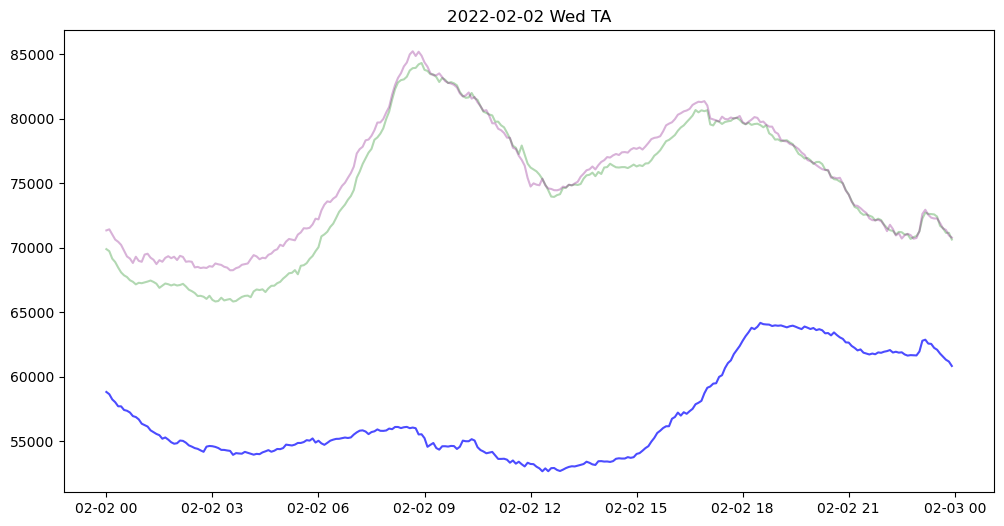

In [45]:
get_graph(df_5m, 'TA')

- 녹색 선이 설날

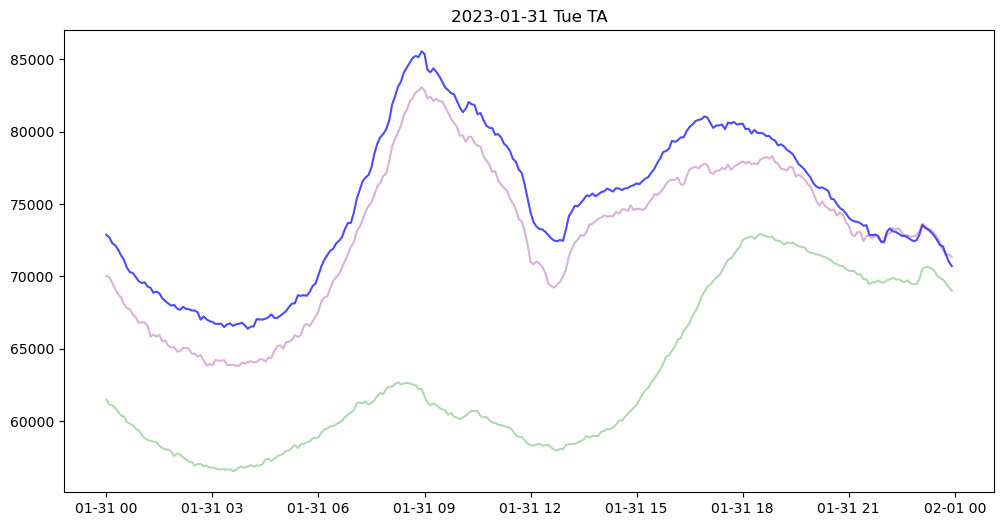

In [47]:
get_graph(df_5m, 'TA')

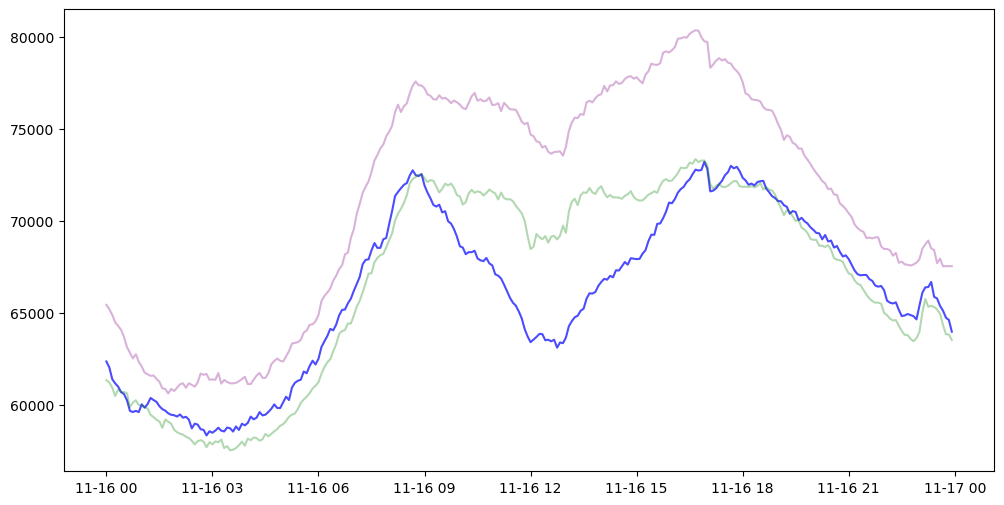

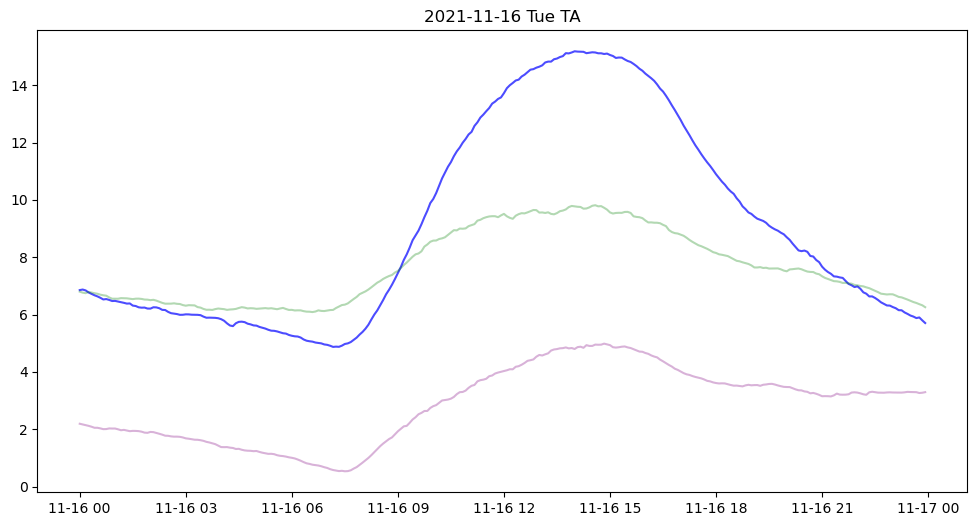

In [66]:
get_graph(df_5m, 'TA')

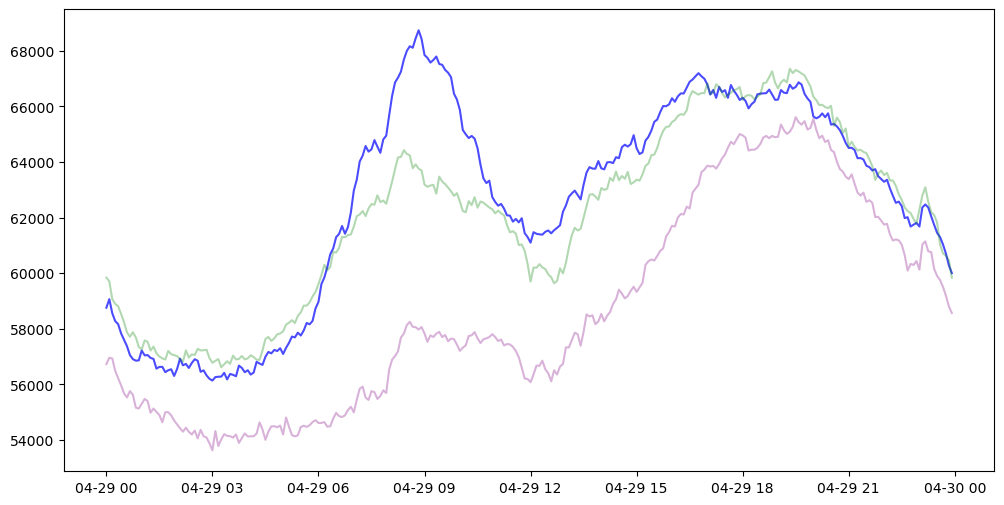

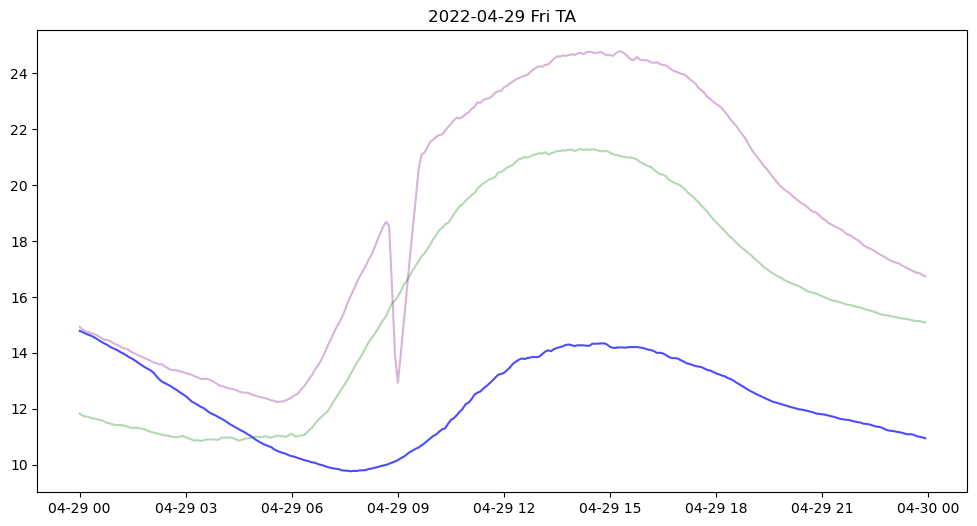

In [83]:
get_graph(df_5m, 'TA')

In [89]:
df_5m.loc['2022-05-06 08:00':'2022-05-06 10:00', 'TA']

YYMMDDHHMI
2022-05-06 08:00:00    16.918701
2022-05-06 08:05:00    17.100529
2022-05-06 08:10:00    17.323438
2022-05-06 08:15:00    17.503944
2022-05-06 08:20:00    17.743017
2022-05-06 08:25:00    18.026731
2022-05-06 08:30:00    18.273842
2022-05-06 08:35:00    18.514629
2022-05-06 08:40:00    18.686981
2022-05-06 08:45:00    18.554910
2022-05-06 08:50:00    16.398128
2022-05-06 08:55:00    13.941507
2022-05-06 09:00:00    12.935510
2022-05-06 09:05:00    13.984091
2022-05-06 09:10:00    15.080616
2022-05-06 09:15:00    16.218265
2022-05-06 09:20:00    17.330697
2022-05-06 09:25:00    18.373872
2022-05-06 09:30:00    19.447449
2022-05-06 09:35:00    20.547746
2022-05-06 09:40:00    21.095639
2022-05-06 09:45:00    21.167987
2022-05-06 09:50:00    21.344148
2022-05-06 09:55:00    21.561801
2022-05-06 10:00:00    21.625024
Name: TA, dtype: float64

In [90]:
df_valid = pd.read_parquet('./data/5m.parquet')
df_valid

In [91]:
df_valid

,도,YYMMDDHHMI,TA,HM,TD,TG,TS,PA,PS
index,,,,,,,,,
0,강원도,2021-03-08 00:00:00,0.753750,86.225000,-1.323750,-2.590000,0.162500,1001.312857,1028.000000
1,강원도,2021-03-08 00:05:00,0.695000,86.482500,-1.343750,-2.738750,0.146250,1001.318571,1028.011429
2,강원도,2021-03-08 00:10:00,0.737500,86.743750,-1.257500,-2.833750,0.142500,1001.330000,1028.007143
3,강원도,2021-03-08 00:15:00,0.677500,86.720000,-1.308750,-2.786250,0.117500,1001.335714,1028.021429
4,강원도,2021-03-08 00:20:00,0.558750,86.917500,-1.395000,-2.747500,0.081250,1001.311429,1028.015714
...,...,...,...,...,...,...,...,...,...
34267,충청북도,2023-02-19 23:35:00,-1.374286,63.134286,-7.700000,-5.420000,-1.354286,1002.880000,1023.906667
34268,충청북도,2023-02-19 23:40:00,-1.482857,63.388571,-7.737143,-5.665714,-1.405714,1002.916667,1023.976667
34269,충청북도,2023-02-19 23:45:00,-1.511429,63.768571,-7.711429,-5.694286,-1.428571,1002.920000,1023.986667


---

In [1]:
import pandas as pd

In [2]:
df = pd.read_parquet('./data/DATA.parquet')

In [9]:
holiday = pd.read_csv('./data/holidays.csv')

In [6]:
df['weekday'] = df['기준일시'].dt.weekday

In [28]:
df['is_holiday'] = df['기준일시'].dt.date.isin(pd.to_datetime(holiday['locdate'])).astype(int)

C:\Users\jiho\AppData\Local\Temp\ipykernel_13548\277116904.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df['is_holiday'] = df['기준일시'].dt.date.isin(pd.to_datetime(holiday['locdate'])).astype(int)


In [33]:
df_grouped = df.groupby('기준일시').mean().drop(columns='지점')

C:\Users\jiho\AppData\Local\Temp\ipykernel_13548\1983804167.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby('기준일시').mean().drop(columns='지점')


In [70]:
power_demand = pd.read_csv("./data/power_demand_interpolated.csv")
power_demand['기준일시'] = pd.to_datetime(power_demand['기준일시'])
power_demand = power_demand.set_index('기준일시')
power_demand

,현재수요(MW)
기준일시,
2012-06-01 00:00:00,51726.33
2012-06-01 00:05:00,51342.53
2012-06-01 00:10:00,51583.17
2012-06-01 00:15:00,51631.69
2012-06-01 00:20:00,51252.66
...,...
2023-03-20 23:35:00,64475.60
2023-03-20 23:40:00,64211.80
2023-03-20 23:45:00,63576.80


In [71]:
power_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1136160 entries, 2012-06-01 00:00:00 to 2023-03-20 23:55:00
Data columns (total 1 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   현재수요(MW)  1136160 non-null  float64
dtypes: float64(1)
memory usage: 17.3 MB


In [72]:
df_grouped['현재수요(MW)'] = power_demand['현재수요(MW)']

In [46]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def get_graph(df, colname='TA_C'):

    weekday_dict = {0 : "Mon",1: "Tue",2: "Wed",3: "Thu",4: "Fri",5: "Sat",6: "Sun"}

    start_date = datetime.strptime('2021-03-01', '%Y-%m-%d').date()
    end_date = datetime.strptime('2023-03-20', '%Y-%m-%d').date()
    dates = get_dates(start_date, end_date)

    rdm_date = np.random.choice(dates, 1)
    df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')]

    plt.figure(figsize=(12,6))
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d'), '현재수요(MW)'], color = 'blue', alpha = 0.7)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]-timedelta(days=7), '%Y-%m-%d'), '현재수요(MW)'], color = 'green', alpha = 0.3)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]+timedelta(days=7), '%Y-%m-%d'), '현재수요(MW)'], color = 'purple', alpha = 0.3)

    plt.figure(figsize=(12,6))
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d'), colname], color = 'blue', alpha = 0.7)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]-timedelta(days=7), '%Y-%m-%d'), colname], color = 'green', alpha = 0.3)
    plt.plot(df.loc[datetime.strftime(rdm_date[0], '%Y-%m-%d')].index, df.loc[datetime.strftime(rdm_date[0]+timedelta(days=7), '%Y-%m-%d'), colname], color = 'purple', alpha = 0.3)

    plt.title(datetime.strftime(rdm_date[0], '%Y-%m-%d') + ' ' + weekday_dict[rdm_date[0].weekday()])
    plt.show()

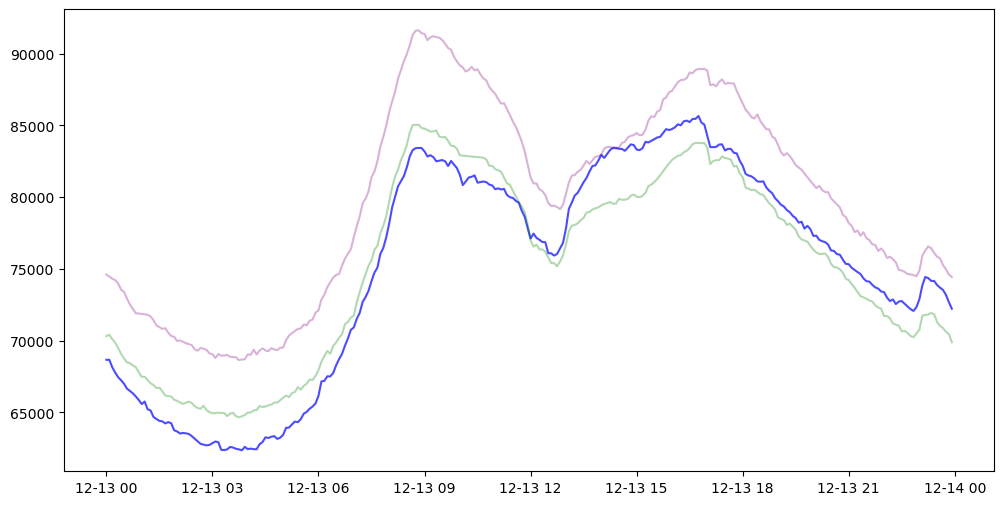

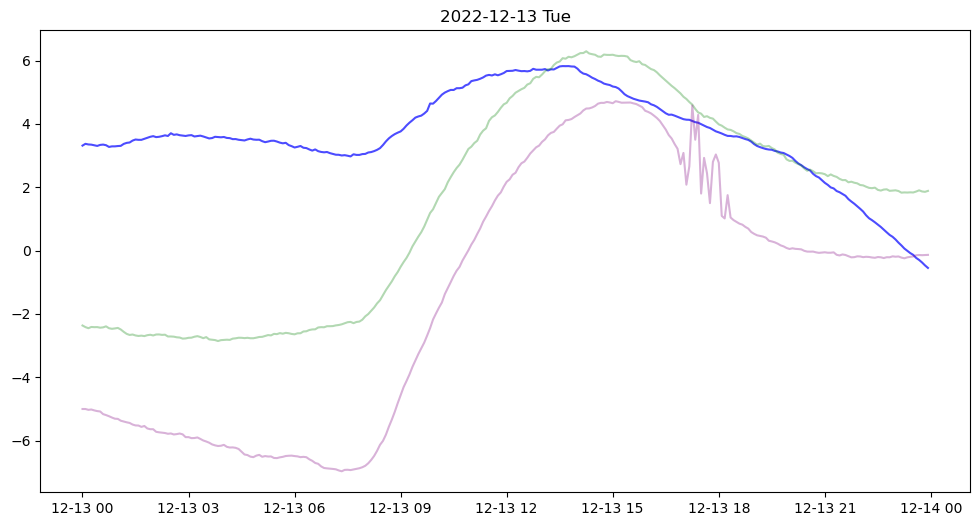

In [77]:
get_graph(df_grouped, colname='기온(°C)')

In [82]:
df_grouped.loc['2022-12-20 16:00':].head(30)

,현재수요(MW),기온(°C),누적강수량(mm),풍향(deg),풍속(m/s),현지기압(hPa),해면기압(hPa),습도(%),일사(MJ/m^2),일조(Sec),Y,weekday,is_holiday
기준일시,,,,,,,,,,,,,
2022-12-20 16:00:00,87402.7,4.378000,0.0,193.856000,1.974000,1014.004000,1024.832000,45.718000,10.748125,27397.400000,76190.7,1.0,0.0
2022-12-20 16:05:00,87699.2,4.330000,0.0,168.418000,1.852000,1013.978000,1024.806000,45.850000,10.791667,27636.600000,75762.4,1.0,0.0
2022-12-20 16:10:00,88002.7,4.260000,0.0,188.850000,1.760000,1013.936000,1024.764000,46.102000,10.829167,27880.080000,75848.6,1.0,0.0
2022-12-20 16:15:00,88153.0,4.184000,0.0,181.844000,1.752000,1013.888000,1024.720000,46.332000,10.864167,28108.240000,75671.7,1.0,0.0
2022-12-20 16:20:00,88165.1,4.090000,0.0,198.116000,1.684000,1013.850000,1024.686000,46.534000,10.891042,28313.460000,75459.8,1.0,0.0
2022-12-20 16:25:00,88293.3,3.958000,0.0,182.070000,1.876000,1013.812000,1024.652000,46.940000,10.915833,28508.820000,74935.4,1.0,0.0
2022-12-20 16:30:00,88674.6,3.820000,0.0,158.642000,1.702000,1013.786000,1024.636000,47.334000,10.937500,28668.880000,74888.5,1.0,0.0
2022-12-20 16:35:00,88631.2,3.648000,0.0,164.888000,1.782000,1013.766000,1024.622000,47.966000,10.953333,28809.660000,74789.8,1.0,0.0
2022-12-20 16:40:00,88848.4,3.538000,0.0,141.912000,1.470000,1013.712000,1024.572000,48.250000,10.966667,28919.760000,74641.6,1.0,0.0


In [84]:
df = df.set_index('기준일시')

In [105]:
df.loc['2022-12-20 18:30:00'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50 entries, 2022-12-20 18:30:00 to 2022-12-20 18:30:00
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시도          50 non-null     object 
 1   지점          50 non-null     int64  
 2   현재수요(MW)    50 non-null     float64
 3   기온(°C)      50 non-null     float64
 4   누적강수량(mm)   49 non-null     float64
 5   풍향(deg)     50 non-null     float64
 6   풍속(m/s)     50 non-null     float64
 7   현지기압(hPa)   50 non-null     float64
 8   해면기압(hPa)   50 non-null     float64
 9   습도(%)       50 non-null     float64
 10  일사(MJ/m^2)  48 non-null     float64
 11  일조(Sec)     49 non-null     float64
 12  Y           50 non-null     float64
 13  weekday     50 non-null     int64  
 14  is_holiday  50 non-null     int32  
dtypes: float64(11), int32(1), int64(2), object(1)
memory usage: 6.1+ KB


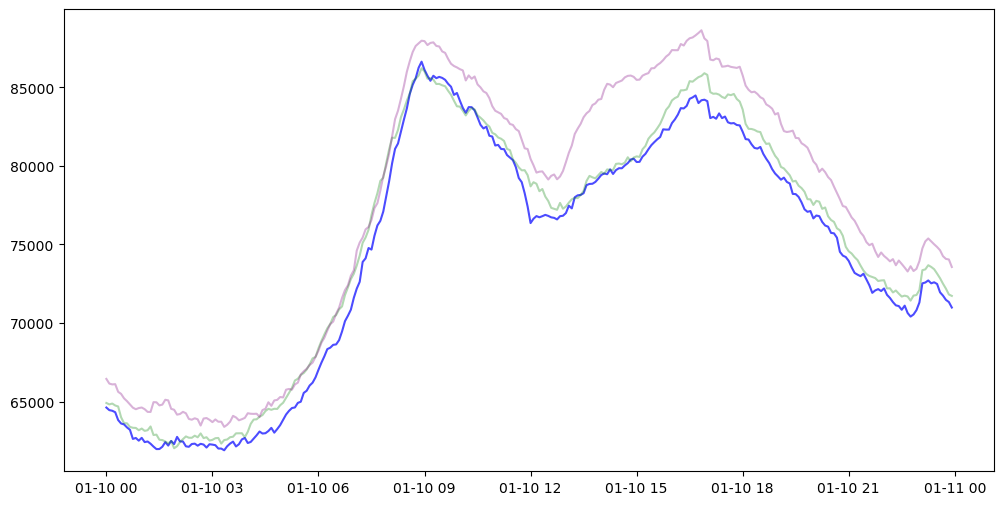

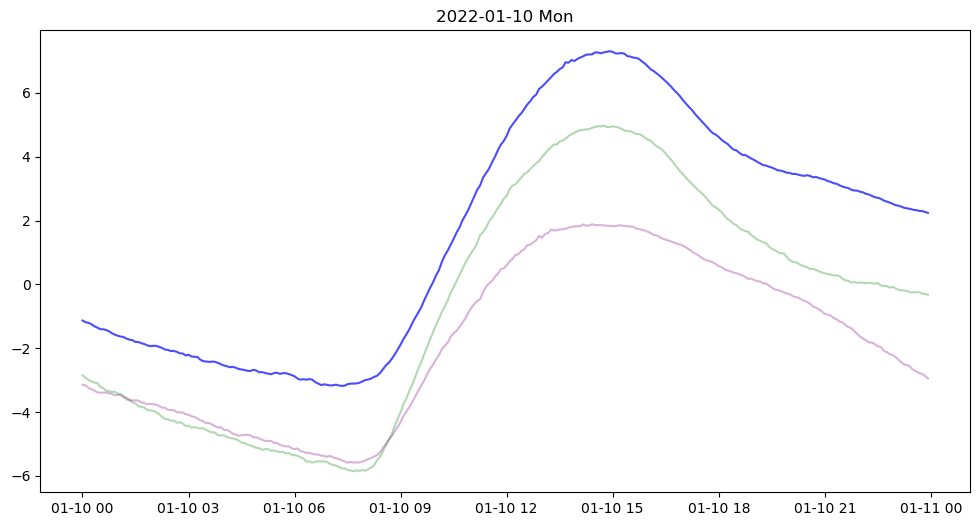

In [156]:
get_graph(df_grouped, colname='기온(°C)')

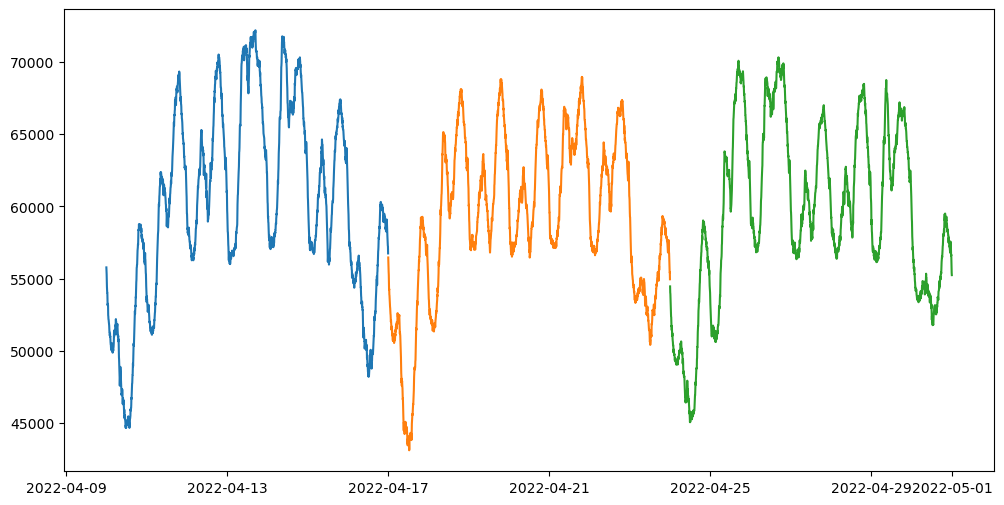

In [123]:
plt.figure(figsize=(12,6))
plt.plot(df_grouped.loc['2022-04-10':'2022-04-16']['현재수요(MW)'])
plt.plot(df_grouped.loc['2022-04-17':'2022-04-23']['현재수요(MW)'])
plt.plot(df_grouped.loc['2022-04-24':'2022-04-30']['현재수요(MW)'])
plt.show()